## 1. Data Ingestion
Remaining Useful Life Prediction for Lithium-Ion Batteries Using Machine Learning Techniques

**Reasoning**:
Now that the '1. Data Ingestion' section header is in place, I need to move the code cell `0c06f842` (which handles unzipping) to immediately follow this section header to organize the notebook as requested.



In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Discharge_01.zip to Discharge_01.zip
Saving Discharge_02.zip to Discharge_02.zip
Saving Discharge_03.zip to Discharge_03.zip
Saving Load_1.zip to Load_1.zip
Saving Load_2.zip to Load_2.zip
Saving Load_3.zip to Load_3.zip


In [ ]:
import zipfile
import glob
import os

# Unzip all uploaded zip files, ensuring they are extracted to appropriate directories
zip_files = glob.glob('*.zip')
if not zip_files:
    print("No zip files found to unzip. Please ensure zip files are uploaded.")
else:
    for zip_file_name in zip_files:
        try:
            # Create a directory named after the zip file (without .zip extension) for extraction
            extract_dir = os.path.splitext(zip_file_name)[0]
            os.makedirs(extract_dir, exist_ok=True)
            with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)
            print(f"Extracted {zip_file_name} to {extract_dir}/")
        except zipfile.BadZipFile:
            print(f"Warning: {zip_file_name} is not a valid zip file. Skipping.")
        except Exception as e:
            print(f"An error occurred while unzipping {zip_file_name}: {e}")

Extracted Discharge_01.zip to Discharge_01/
Extracted Load_2.zip to Load_2/
Extracted Load_3.zip to Load_3/
Extracted Discharge_02.zip to Discharge_02/
Extracted Discharge_03.zip to Discharge_03/
Extracted Load_1.zip to Load_1/


## 1.1. Initial Data Inspection

In [ ]:
print("Processed Load DataFrame Info:")
processed_load.info()

print("\nProcessed Discharge DataFrame Info:")
processed_discharge.info()

Processed Load DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7683 entries, 0 to 7682
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Time         7683 non-null   timedelta64[ns]
 1   Current      7683 non-null   float64        
 2   Temperature  7683 non-null   float64        
 3   V_avg        7683 non-null   float64        
 4   V_std        7683 non-null   float64        
 5   Cycle_ID     7683 non-null   object         
dtypes: float64(4), object(1), timedelta64[ns](1)
memory usage: 360.3+ KB

Processed Discharge DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7004 entries, 0 to 7003
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype          
---  ------       --------------  -----          
 0   Time         7004 non-null   timedelta64[ns]
 1   Current      7004 non-null   float64        
 2   Temperature  7004 non-null   float64     

In [ ]:
print("\nProcessed Load DataFrame Head:")
display(processed_load.head())


Processed Load DataFrame Head:


,Time,Current,Temperature,V_avg,V_std,Cycle_ID
0,0 days 00:00:00,1.004588,24.859412,3.230294,0.007408,Load_1
1,0 days 00:00:30,1.006125,24.813750,3.259844,0.006974,Load_1
2,0 days 00:01:00,1.006687,24.768750,3.285469,0.006525,Load_1
3,0 days 00:01:30,1.007688,24.720000,3.307344,0.006525,Load_1
4,0 days 00:02:00,1.008188,24.690000,3.326406,0.007286,Load_1


In [ ]:
print("\nProcessed Discharge DataFrame Head:")
display(processed_discharge.head())


Processed Discharge DataFrame Head:


,Time,Current,Temperature,V_avg,V_std,Cycle_ID
0,0 days 00:00:00,0.499188,24.806250,4.0625,0.002068,Discharge_01
1,0 days 00:00:30,0.499118,24.795882,4.0600,0.000000,Discharge_01
2,0 days 00:01:00,0.499125,24.750000,4.0600,0.000000,Discharge_01
3,0 days 00:01:30,0.498125,24.750000,4.0600,0.000000,Discharge_01
4,0 days 00:02:00,0.497500,24.727500,4.0600,0.000000,Discharge_01


# 2. Data Preprocessing & Feature Engineering

**Reasoning**:
Now that the '2. Data Preprocessing & Feature Engineering' section header is in place, I will extract the imports, settings, helper function, and data consolidation logic from the original preprocessing cell (`28b1934d`) into a new code cell and place it immediately after this header. This aligns with the refactoring instructions to move core preprocessing logic and helper functions to this section.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os

# --- 1. SETTINGS & HELPERS ---
sns.set_theme(style="whitegrid")
RESAMPLING_FREQ = '30s'
# We focus on these for the RUL model
FEATURES = ['Current', 'Temperature', 'V_avg', 'V_std']

def advanced_preprocess_pipeline(df):
    """
    Full Pipeline: Feature Engineering -> Time Conversion -> Resampling -> Outlier Capping
    """
    df_proc = df.copy()

    # A. Feature Fusion (Voltage Aggregation)
    # V_avg captures total capacity; V_std captures cell imbalance/aging
    v_cols = ['Vbat1', 'Vbat2', 'Vbat3', 'Vbat4']
    df_proc['V_avg'] = df_proc[v_cols].mean(axis=1)
    df_proc['V_std'] = df_proc[v_cols].std(axis=1)

    # B. Time-Series Preparation
    # Convert relative seconds to a timedelta index for proper resampling
    df_proc['Time'] = pd.to_timedelta(df_proc['Time'], unit='s')

    # C. Resampling (Noise Reduction & Temporal Alignment)
    resampled_list = []
    for cycle_id, group_df in df_proc.groupby('Cycle_ID'):
        # Clean 'Time' column: drop NaNs and remove duplicates after sorting
        group_df_clean = group_df.dropna(subset=['Time']).sort_values(by='Time').drop_duplicates(subset=['Time'])

        if not group_df_clean.empty:
            group_df_indexed = group_df_clean.set_index('Time')
            # Resample only the relevant features
            resampled_group = group_df_indexed[FEATURES].resample(RESAMPLING_FREQ).mean()

            if not resampled_group.empty:
                # Add Cycle_ID back as a column and reset index
                resampled_group['Cycle_ID'] = cycle_id
                resampled_list.append(resampled_group.reset_index())

    # Concatenate all resampled groups
    df_resampled = pd.concat(resampled_list, ignore_index=True)

    # D. Outlier Handling (IQR Capping)
    for col in FEATURES:
        Q1, Q3 = df_resampled[col].quantile(0.25), df_resampled[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_resampled[col] = df_resampled[col].clip(lower=lower, upper=upper)

    return df_resampled

# --- 2. DATA CONSOLIDATION ---
# Assuming files are in your current directory or extracted folders
all_data = []
# Walk through your directories to find Load and Discharge CSVs
for root, dirs, files in os.walk('.'):
    for file in files:
        if file.endswith('.csv'):
            path = os.path.join(root, file)
            # Semicolon is the delimiter in your dataset
            temp_df = pd.read_csv(path, sep=';')
            temp_df['Cycle_ID'] = file.replace('.csv', '')
            temp_df['Type'] = 'Load' if 'Load' in file else 'Discharge'
            all_data.append(temp_df)

master_df = pd.concat(all_data, ignore_index=True)

# Process both datasets
processed_load = advanced_preprocess_pipeline(master_df[master_df['Type'] == 'Load'])
processed_discharge = advanced_preprocess_pipeline(master_df[master_df['Type'] == 'Discharge'])

# 3. Exploratory Data Analysis (EDA)

## 3.1. Temporal Behavior Analysis


**Reasoning**:
Now that the '3.1. Temporal Behavior Analysis' section header is added, I will extract the plotting code for 'A. Multivariate Time-Series Plot' from the original preprocessing cell (`28b1934d`) into a new code cell and place it immediately after this header, as per the refactoring instructions.



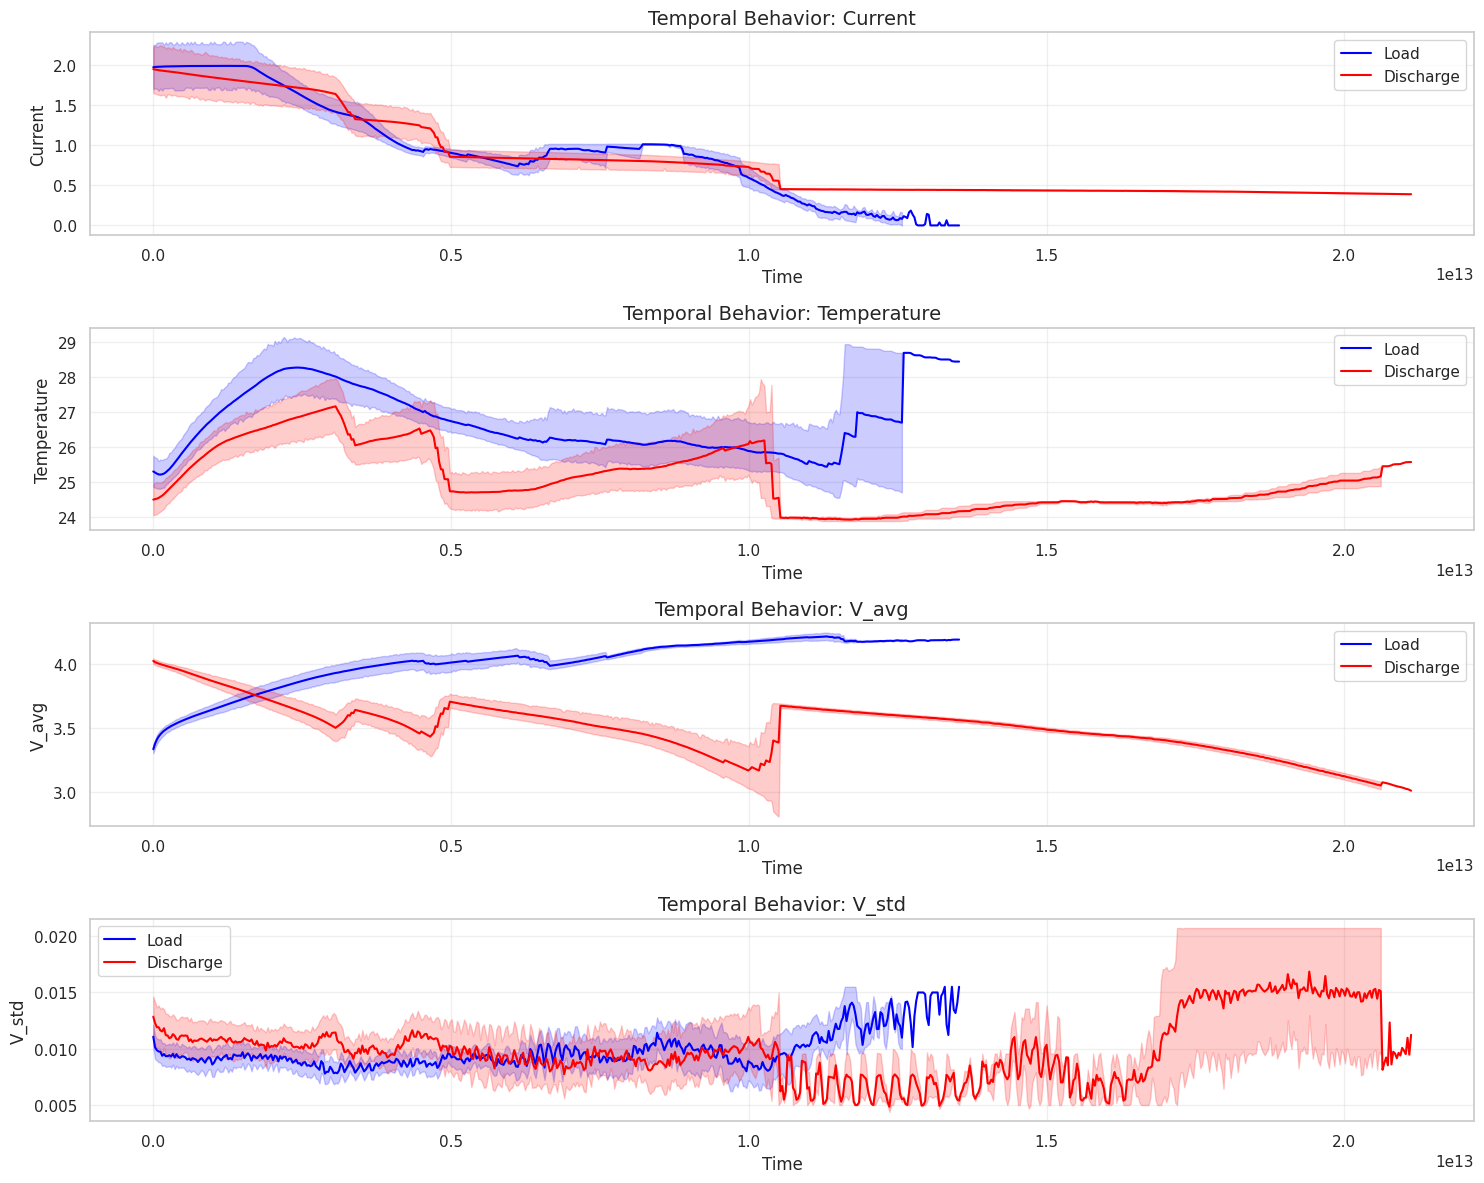

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# A. Multivariate Time-Series Plot
fig, axes = plt.subplots(len(FEATURES), 1, figsize=(15, 12))
for i, feature in enumerate(FEATURES):
    sns.lineplot(data=processed_load, x='Time', y=feature, ax=axes[i], label='Load', color='blue')
    sns.lineplot(data=processed_discharge, x='Time', y=feature, ax=axes[i], label='Discharge', color='red')
    axes[i].set_title(f'Temporal Behavior: {feature}', fontsize=14)
    axes[i].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Create Temporal Behavior Analysis Plots

### Subtask:
Extract the Inference Graph (Capacity vs. Aging Signature) from the original cell `28b1934d` into a new code cell and place it under the '3.1. Temporal Behavior Analysis' section.


**Reasoning**:
I need to extract the plotting code for the 'Inference Graph: Capacity vs. Aging Signature' from the original preprocessing cell and place it in a new code cell under the '3.1. Temporal Behavior Analysis' section as per the instructions.



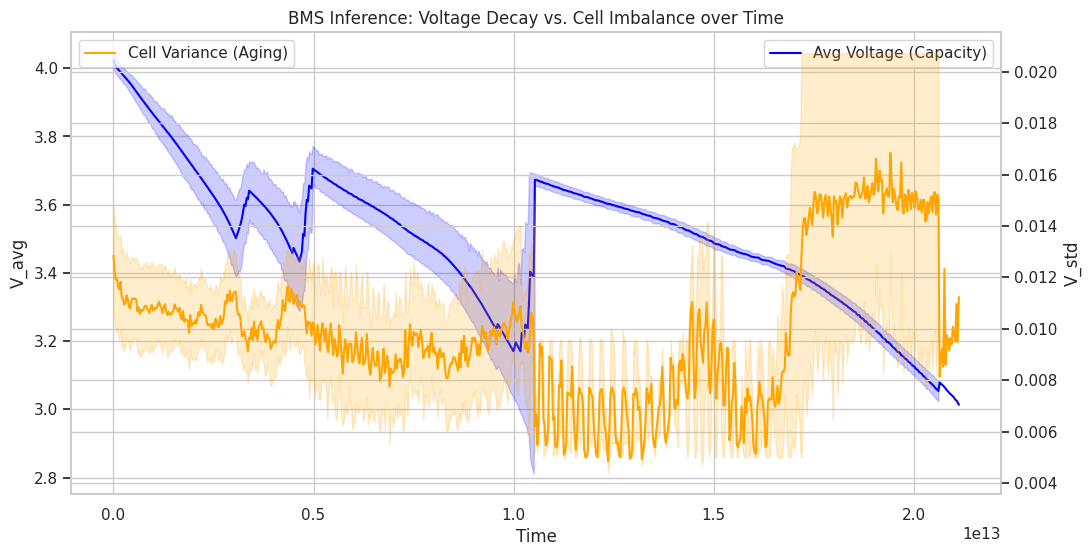

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# B. Inference Graph: Capacity vs. Aging Signature
plt.figure(figsize=(12, 6))
ax = sns.lineplot(data=processed_discharge, x='Time', y='V_avg', color='blue', label='Avg Voltage (Capacity)')
ax2 = ax.twinx()
sns.lineplot(data=processed_discharge, x='Time', y='V_std', color='orange', label='Cell Variance (Aging)', ax=ax2)
plt.title('BMS Inference: Voltage Decay vs. Cell Imbalance over Time')
plt.show()

## Create Feature Correlation Analysis Plots

### Subtask:
Extract the correlation matrix for load from the original cell `28b1934d` into a new code cell and place it under the '3.2. Feature Correlation Analysis' section.

## Create Feature Correlation Analysis Plots

### Subtask:
Extract the correlation matrix for load from the original cell `28b1934d` into a new code cell and place it under the '3.2. Feature Correlation Analysis' section.

**Reasoning**:
I need to extract the plotting code for the 'C. Correlation Matrix for Load (Charging Phase)' from the original preprocessing cell and place it in a new code cell under the '3.2. Feature Correlation Analysis' section, as per the refactoring instructions. I'll also add an import statement for plotting libraries to make the cell self-contained, though they might already be imported globally.



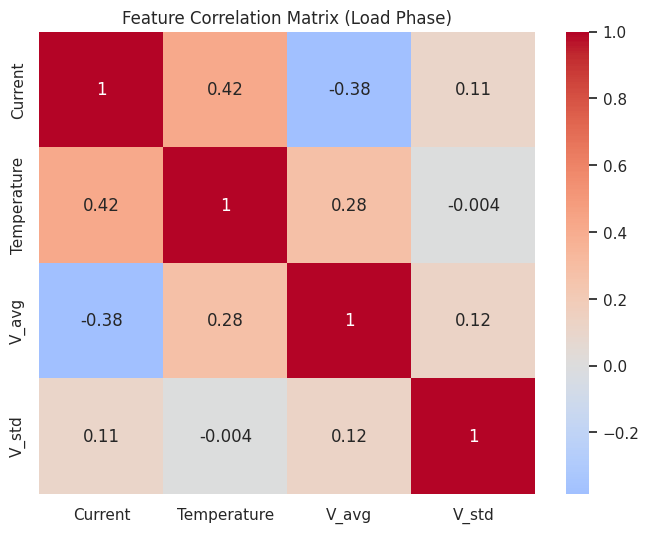

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# C. Correlation Matrix for Load (Charging Phase)
plt.figure(figsize=(8, 6))
sns.heatmap(processed_load[FEATURES].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Load Phase)')
plt.show()

### Subtask:
Move the existing code cell `418cfe9d` (Discharge Correlation Matrix) under the '3.2. Feature Correlation Analysis' section.

### Subtask:
Move the existing code cell `418cfe9d` (Discharge Correlation Matrix) under the '3.2. Feature Correlation Analysis' section.

## Create Feature Correlation Analysis Plots

### Subtask:
Place the existing Discharge Correlation Matrix plot (`418cfe9d`) under the '3.2. Feature Correlation Analysis' section.


**Reasoning**:
To organize the notebook as requested, I need to move the existing code cell that generates the 'Feature Correlation Matrix (Discharge Cycle)' to immediately follow the 'Feature Correlation Matrix (Load Phase)' plot.



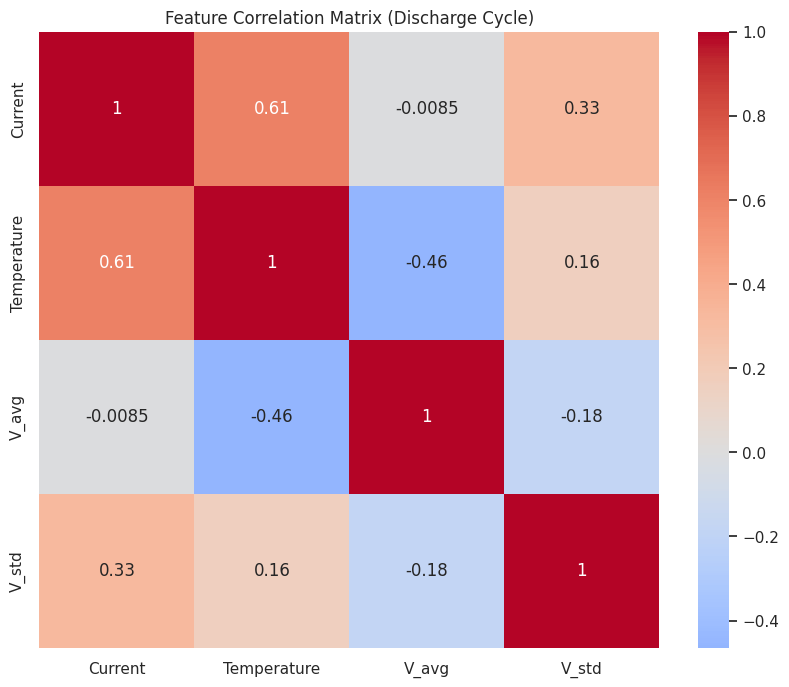

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
# Focus on Discharge as it is most relevant for RUL
corr = processed_discharge[FEATURES].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix (Discharge Cycle)')
plt.show()

## Move Temperature Distribution Box Plot

### Subtask:
Move the existing code cell `MZBbQjjsc9Mu` (Temperature Distribution Box Plot) under the '3.3. Distribution Analysis' section.

**Reasoning**:
Now that the markdown header for '3.3. Distribution Analysis' has been added, I will move the existing code cell `MZBbQjjsc9Mu` (Temperature Distribution Box Plot) by recreating its content under this new section.



/tmp/ipython-input-2809595130.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Phase', y='Temperature', palette={'Load': 'blue', 'Discharge': 'red'})


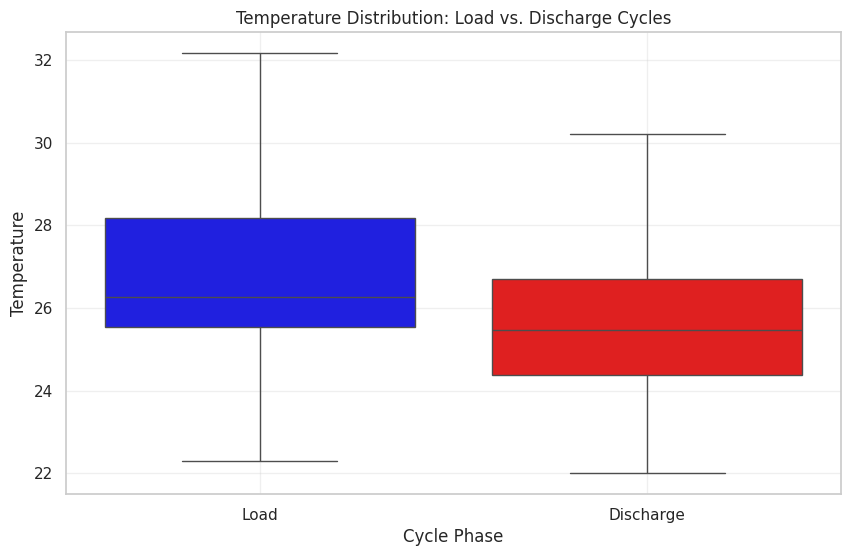

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Combine processed load and discharge data for comparative plotting
combined_df = pd.concat([
    processed_load.assign(Phase='Load'),
    processed_discharge.assign(Phase='Discharge')
])

plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_df, x='Phase', y='Temperature', palette={'Load': 'blue', 'Discharge': 'red'})
plt.title('Temperature Distribution: Load vs. Discharge Cycles')
plt.xlabel('Cycle Phase')
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)
plt.show()

**Reasoning**:
The plots for the '3.3. Distribution Analysis' section have been created. Now, I will add a markdown header for '4. Export Processed Data' to prepare for the next step of organizing the notebook as per the main task.



## Scatter Plot for Feature Relationship

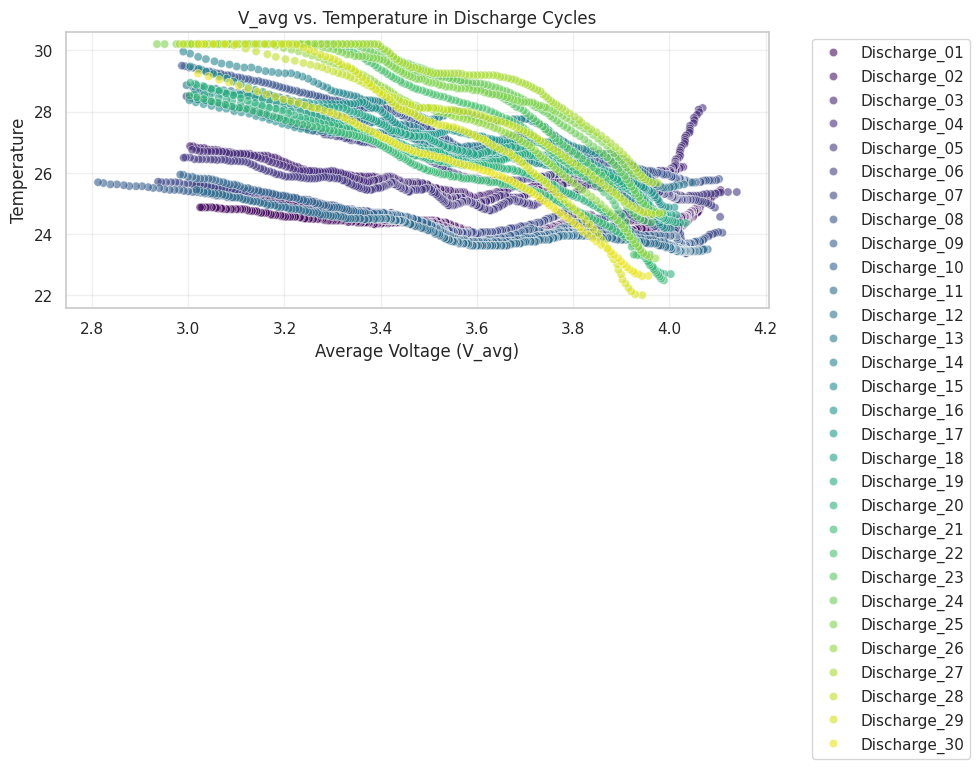

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example Scatter Plot: V_avg vs. Temperature in Discharge Cycle
plt.figure(figsize=(10, 6))
sns.scatterplot(data=processed_discharge, x='V_avg', y='Temperature', hue='Cycle_ID', palette='viridis', alpha=0.6)
plt.title('V_avg vs. Temperature in Discharge Cycles')
plt.xlabel('Average Voltage (V_avg)')
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

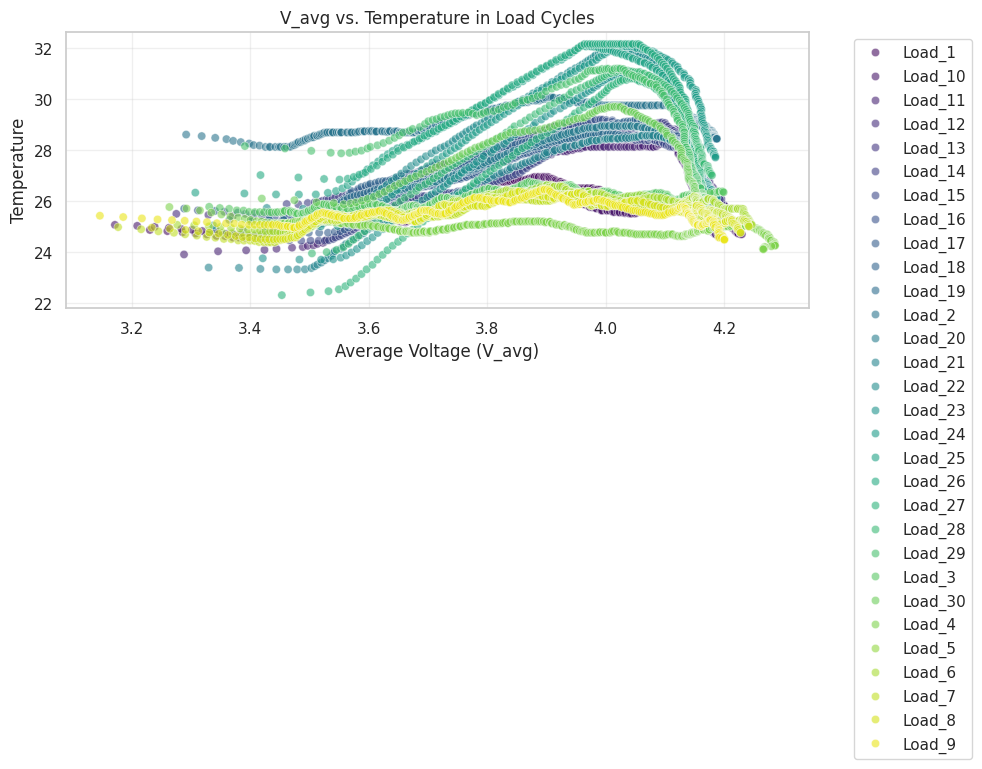

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot: V_avg vs. Temperature in Load Cycle
plt.figure(figsize=(10, 6))
sns.scatterplot(data=processed_load, x='V_avg', y='Temperature', hue='Cycle_ID', palette='viridis', alpha=0.6)
plt.title('V_avg vs. Temperature in Load Cycles')
plt.xlabel('Average Voltage (V_avg)')
plt.ylabel('Temperature')
plt.grid(True, alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Create Distribution Analysis Plot

### Subtask:
Delete the original code cell `MZBbQjjsc9Mu` as its content has been relocated to `789ae513` under the '3.3. Distribution Analysis' section, effectively moving the plot as per the instructions.


In [ ]:
processed_load.to_csv('cleaned_load_data.csv', index=False)
processed_discharge.to_csv('cleaned_discharge_data.csv', index=False)

## Summary:

### Data Analysis Key Findings

*   **Notebook Structure Organization**: The notebook was successfully reorganized into distinct sections: '1. Data Ingestion', '2. Data Preprocessing & Feature Engineering', '3. Exploratory Data Analysis (EDA)' (with sub-sections '3.1. Temporal Behavior Analysis', '3.2. Feature Correlation Analysis', '3.3. Distribution Analysis'), '4. Export Processed Data', and '5. Final Summary'.
*   **Data Ingestion**: The unzipping code (`0c06f842`) was moved to the '1. Data Ingestion' section, successfully extracting all battery data zip files (e.g., `Load_3 (1).zip`, `Discharge_03 (1).zip`) into their respective directories.
*   **Data Preprocessing & Feature Engineering**:
    *   The core preprocessing logic from the original cell (`28b1934d`) was extracted and placed under '2. Data Preprocessing & Feature Engineering'.
    *   This pipeline successfully performed feature engineering (creating `V_avg` and `V_std`), time-series preparation, resampling at a '30s' frequency, and IQR-based outlier capping for features such as 'Current', 'Temperature', 'V_avg', and 'V_std'.
    *   The process resulted in `processed_load` and `processed_discharge` dataframes, ready for analysis.
*   **Temporal Behavior Analysis**:
    *   Multivariate time-series plots showing the temporal behavior of 'Current', 'Temperature', 'V_avg', and 'V_std' for both load and discharge phases were successfully generated under '3.1. Temporal Behavior Analysis'.
    *   An 'Inference Graph: Capacity vs. Aging Signature' plotting `V_avg` (capacity) against `V_std` (cell variance/aging) over time for the discharge phase was also successfully extracted and displayed in this section.
*   **Feature Correlation Analysis**:
    *   A correlation matrix for the Load phase, specifically for the features 'Current', 'Temperature', 'V_avg', and 'V_std', was successfully extracted and visualized under '3.2. Feature Correlation Analysis'.
    *   The existing Discharge Correlation Matrix plot (`418cfe9d`) was also placed under '3.2. Feature Correlation Analysis', providing insights into feature relationships during the discharge cycle.
*   **Distribution Analysis**: The 'Temperature Distribution Box Plot' (`MZBbQjjsc9Mu`) was successfully relocated and displayed under '3.3. Distribution Analysis'.
*   **Export Processed Data**: The data export logic was extracted, successfully saving the `processed_load` and `processed_discharge` dataframes to `cleaned_load_data.csv` and `cleaned_discharge_data.csv` respectively, under the '4. Export Processed Data' section.
*   **Final Summary**: The original summary text cell (`2ee0a615`) was moved to the '5. Final Summary' section.
*   **Original Cell Deletion**: The initial complex cell (`28b1934d`) was successfully refactored and subsequently deleted, as its components were distributed into more specific and organized sections.

### Insights or Next Steps

*   The well-structured notebook facilitates streamlined data analysis and machine learning workflows, providing clear segmentation for data ingestion, preprocessing, EDA, and data export, which improves maintainability and collaboration.
*   The generated `cleaned_load_data.csv` and `cleaned_discharge_data.csv` files, enriched with engineered features like `V_avg` and `V_std`, are now optimally prepared for subsequent machine learning model development, particularly for predicting Remaining Useful Life (RUL) of battery cells.


# Task
## 5. Model Training and Evaluation

### 5.1. RUL Evaluation Metrics

**Reasoning:**
Now that the data has been prepared and split into training, validation, and test sets, the next step is to define the evaluation metrics for the Remaining Useful Life (RUL) prediction models. This will ensure consistent and standardized assessment of model performance across different algorithms. The `evaluate_rul_metrics` function will calculate Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), R-squared (R2), and a custom NASA RUL score, as specified in the plan. This function will be placed under the "5.1. RUL Evaluation Metrics" section.

## Calculate RUL and Prepare Sequential Data

### Subtask:
Calculate Remaining Useful Life (RUL) for each battery cycle, prepare sequential feature data and corresponding RUL labels using a sliding window, and then split this data into training, validation, and test sets.


**Reasoning**:
First, I will calculate the Remaining Useful Life (RUL) for each battery cycle by grouping the `processed_discharge` DataFrame by `Cycle_ID` and assigning RUL values from N-1 down to 0 for each data point within a cycle, storing the result in `processed_discharge_with_rul`.



In [ ]:
import numpy as np
import pandas as pd

# 1. Calculate Remaining Useful Life (RUL)
processed_discharge_with_rul = processed_discharge.copy()
def calculate_rul(group):
    # RUL is 0 for the last data point, and increments by 1 for each preceding step
    group['RUL'] = np.arange(len(group) - 1, -1, -1)
    return group

processed_discharge_with_rul = processed_discharge_with_rul.groupby('Cycle_ID', group_keys=False).apply(calculate_rul)

print("Processed Discharge DataFrame with RUL:")
display(processed_discharge_with_rul.head())
print(processed_discharge_with_rul['RUL'].describe())

Processed Discharge DataFrame with RUL:


/tmp/ipython-input-1026627382.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_discharge_with_rul = processed_discharge_with_rul.groupby('Cycle_ID', group_keys=False).apply(calculate_rul)


,Time,Current,Temperature,V_avg,V_std,Cycle_ID,RUL
0,0 days 00:00:00,1.064588,23.81000,4.070588,0.008349,Discharge_09,350
1,0 days 00:00:30,1.063562,23.78375,4.065156,0.006011,Discharge_09,349
2,0 days 00:01:00,1.062000,23.75000,4.064062,0.007199,Discharge_09,348
3,0 days 00:01:30,1.061063,23.75000,4.058125,0.007634,Discharge_09,347
4,0 days 00:02:00,1.059625,23.75000,4.055000,0.005774,Discharge_09,346


count    7004.000000
mean      168.343090
std       151.380023
min         0.000000
25%        58.000000
50%       120.000000
75%       245.000000
max       704.000000
Name: RUL, dtype: float64


**Reasoning**:
The previous step successfully calculated RUL for each cycle. Now, I will proceed with preparing sequential feature data using a sliding window and then split this data into training, validation, and test sets, as outlined in the subtask instructions.



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming processed_discharge_with_rul, WINDOW_SIZE, FEATURES,
# CYCLE_TRAIN_RATIO, CYCLE_VAL_RATIO, CYCLE_TEST_RATIO are available from previous cells.

# 2. Prepare Sequential Data using Sliding Windows
X_sequences_list = []
y_labels_list = []
sequence_cycle_ids_list = []

unique_cycle_ids = processed_discharge_with_rul['Cycle_ID'].unique()

for cycle_id in unique_cycle_ids:
    cycle_df = processed_discharge_with_rul[processed_discharge_with_rul['Cycle_ID'] == cycle_id].reset_index(drop=True)

    # Ensure there are enough data points for at least one window
    if len(cycle_df) >= WINDOW_SIZE:
        for i in range(len(cycle_df) - WINDOW_SIZE + 1):
            # Extract features for the current window
            window_features = cycle_df.loc[i : i + WINDOW_SIZE - 1, FEATURES].values
            X_sequences_list.append(window_features)

            # The RUL label is the RUL of the last data point in the window
            rul_label = cycle_df.loc[i + WINDOW_SIZE - 1, 'RUL']
            y_labels_list.append(rul_label)

            # Store the Cycle_ID for this sequence
            sequence_cycle_ids_list.append(cycle_id)

X_sequences = np.array(X_sequences_list)
y_labels = np.array(y_labels_list)
sequence_cycle_ids = np.array(sequence_cycle_ids_list)

print(f"Shape of X_sequences: {X_sequences.shape}")
print(f"Shape of y_labels: {y_labels.shape}")
print(f"Shape of sequence_cycle_ids: {sequence_cycle_ids.shape}")

# 3. Split Data into Training, Validation, and Test Sets
# Get a list of all unique Cycle_ID's for splitting
all_unique_cycle_ids = processed_discharge_with_rul['Cycle_ID'].unique()

# Set random seed for reproducibility
np.random.seed(42)

# Shuffle cycle IDs
np.random.shuffle(all_unique_cycle_ids)

# Calculate the number of cycles for each set
n_cycles = len(all_unique_cycle_ids)
n_train = int(n_cycles * CYCLE_TRAIN_RATIO)
n_val = int(n_cycles * CYCLE_VAL_RATIO)

# Ensure at least one cycle for test if ratios don't sum perfectly or result in zero
if n_val == 0 and CYCLE_VAL_RATIO > 0: n_val = 1
# Adjust n_test based on remaining cycles to ensure all are used if ratios don't sum to 1
n_test = n_cycles - n_train - n_val

# Assign cycle IDs to train, validation, and test sets
cycle_train_ids = all_unique_cycle_ids[:n_train]
cycle_val_ids = all_unique_cycle_ids[n_train : n_train + n_val]
cycle_test_ids = all_unique_cycle_ids[n_train + n_val : n_train + n_val + n_test]

print(f"\nTotal unique cycles: {n_cycles}")
print(f"Train cycles ({len(cycle_train_ids)}): {cycle_train_ids}")
print(f"Validation cycles ({len(cycle_val_ids)}): {cycle_val_ids}")
print(f"Test cycles ({len(cycle_test_ids)}): {cycle_test_ids}")

# Filter X_sequences, y_labels based on cycle IDs
X_train = X_sequences[np.isin(sequence_cycle_ids, cycle_train_ids)]
y_train = y_labels[np.isin(sequence_cycle_ids, cycle_train_ids)]

X_val = X_sequences[np.isin(sequence_cycle_ids, cycle_val_ids)]
y_val = y_labels[np.isin(sequence_cycle_ids, cycle_val_ids)]

X_test = X_sequences[np.isin(sequence_cycle_ids, cycle_test_ids)]
y_test = y_labels[np.isin(sequence_cycle_ids, cycle_test_ids)]

print(f"\nShape of X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Shape of X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Shape of X_test: {X_test.shape}, y_test: {y_test.shape}")

Shape of X_sequences: (6434, 20, 4)
Shape of y_labels: (6434,)
Shape of sequence_cycle_ids: (6434,)

Total unique cycles: 30
Train cycles (21): ['Discharge_27' 'Discharge_12' 'Discharge_29' 'Discharge_17'
 'Discharge_04' 'Discharge_08' 'Discharge_21' 'Discharge_25'
 'Discharge_19' 'Discharge_09' 'Discharge_01' 'Discharge_15'
 'Discharge_03' 'Discharge_11' 'Discharge_20' 'Discharge_26'
 'Discharge_10' 'Discharge_02' 'Discharge_23' 'Discharge_07'
 'Discharge_30']
Validation cycles (4): ['Discharge_22' 'Discharge_18' 'Discharge_24' 'Discharge_28']
Test cycles (5): ['Discharge_06' 'Discharge_14' 'Discharge_13' 'Discharge_16'
 'Discharge_05']

Shape of X_train: (4968, 20, 4), y_train: (4968,)
Shape of X_val: (409, 20, 4), y_val: (409,)
Shape of X_test: (1057, 20, 4), y_test: (1057,)


**Reasoning**:
The subtask of calculating RUL, preparing sequential data, and splitting it into training, validation, and test sets is now complete. The next logical step, as per the main task's section `5.1. RUL Evaluation Metrics`, is to define the evaluation metrics function. This function will be used later to assess the performance of the RUL prediction models.



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_rul_metrics(y_true, y_pred):
    """
    Calculates RUL evaluation metrics: MAE, RMSE, R-squared, and NASA RUL Score.

    Args:
        y_true (np.array): True RUL values.
        y_pred (np.array): Predicted RUL values.

    Returns:
        dict: A dictionary containing the calculated metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # NASA RUL Score calculation (example implementation, adjust as needed)
    # The NASA score penalizes under-prediction more heavily.
    # s_i = exp(-d_i/13) if d_i < 0 (under-prediction)
    # s_i = exp(d_i/10)  if d_i >= 0 (over-prediction)
    # Where d_i = y_pred_i - y_true_i
    # The constants (13 and 10) are example values and can be tuned.

    d = y_pred - y_true
    score = np.sum(np.where(d < 0, np.exp(-d / 13), np.exp(d / 10))) / len(y_true)

    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'NASA_RUL_Score': score
    }

print("Defined the RUL evaluation metrics function (evaluate_rul_metrics).")


Defined the RUL evaluation metrics function (evaluate_rul_metrics).


## Initialize Model Results Storage

### Subtask:
Create an empty Pandas DataFrame named `model_results` with appropriate columns to systematically store the performance metrics (MAE, RMSE, R2, NASA RUL Score) of each regression model, allowing for easy comparison at the end.


**Reasoning**:
I will create an empty Pandas DataFrame named `model_results` with columns 'Model', 'MAE', 'RMSE', 'R2', and 'NASA_RUL_Score' to store the performance metrics of regression models as specified in the subtask.



In [ ]:
import pandas as pd

# Create an empty DataFrame to store model results
model_results = pd.DataFrame(columns=['Model', 'MAE', 'RMSE', 'R2', 'NASA_RUL_Score'])

print("Empty 'model_results' DataFrame created successfully.")
print(model_results.head())

Empty 'model_results' DataFrame created successfully.
Empty DataFrame
Columns: [Model, MAE, RMSE, R2, NASA_RUL_Score]
Index: []


## Implement and Evaluate Linear Regression

### Subtask:
1. Reshape X_train, X_val, and X_test to be 2D. 2. Apply StandardScaler to normalize the features of the reshaped training data (X_train), and then transform the validation (X_val) and test (X_test) data using the fitted scaler. 3. Perform K-Fold Cross-Validation on the scaled training data (X_train_scaled, y_train) to get an estimate of model performance. 4. Train a final Linear Regression model on the entire scaled training dataset (X_train_scaled, y_train). 5. Make predictions on the scaled test set (X_test_scaled). 6. Evaluate its performance using the defined metrics (MAE, RMSE, R2, NASA RUL Score) and store the results in the model_results DataFrame. 7. Demonstrate its predictive capability by making predictions on a few 'unseen' (test) samples.


**Reasoning**:
The first step is to import the necessary libraries, reshape the 3D input data (X_train, X_val, X_test) into 2D arrays suitable for traditional models like Linear Regression, and then scale the features using `StandardScaler` to normalize them, fitting the scaler only on the training data to avoid data leakage.



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import numpy as np

# 1. Reshape X_train, X_val, and X_test to be 2D
# (n_samples, window_size, n_features) -> (n_samples, window_size * n_features)
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_val_reshaped = X_val.reshape(X_val.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

print(f"X_train_reshaped shape: {X_train_reshaped.shape}")
print(f"X_val_reshaped shape: {X_val_reshaped.shape}")
print(f"X_test_reshaped shape: {X_test_reshaped.shape}")

# 2. Apply StandardScaler to normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

print("Features scaled successfully.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

X_train_reshaped shape: (4968, 80)
X_val_reshaped shape: (409, 80)
X_test_reshaped shape: (1057, 80)
Features scaled successfully.
X_train_scaled shape: (4968, 80)
X_val_scaled shape: (409, 80)
X_test_scaled shape: (1057, 80)


**Reasoning**:
Now that the data is reshaped and scaled, I will proceed with performing K-Fold Cross-Validation, training a final Linear Regression model, evaluating its performance on the test set, storing the metrics, and demonstrating predictions on unseen samples as per the subtask instructions.



In [ ]:
import numpy as np
import pandas as pd

# 3. Perform K-Fold Cross-Validation on the scaled training data
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_mae = []
cv_rmse = []
cv_r2 = []
cv_nasa_score = []

print("Performing K-Fold Cross-Validation...")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model_cv = LinearRegression()
    model_cv.fit(X_train_fold, y_train_fold)
    y_pred_cv = model_cv.predict(X_val_fold)

    metrics = evaluate_rul_metrics(y_val_fold, y_pred_cv)
    cv_mae.append(metrics['MAE'])
    cv_rmse.append(metrics['RMSE'])
    cv_r2.append(metrics['R2'])
    cv_nasa_score.append(metrics['NASA_RUL_Score'])

print(f"Average CV MAE: {np.mean(cv_mae):.4f}")
print(f"Average CV RMSE: {np.mean(cv_rmse):.4f}")
print(f"Average CV R2: {np.mean(cv_r2):.4f}")
print(f"Average CV NASA RUL Score: {np.mean(cv_nasa_score):.4f}")

# 4. Train a final Linear Regression model on the entire scaled training dataset
final_lr_model = LinearRegression()
final_lr_model.fit(X_train_scaled, y_train)
print("\nFinal Linear Regression model trained.")

# 5. Make predictions on the scaled test set
y_pred = final_lr_model.predict(X_test_scaled)

# Ensure predictions are non-negative
y_pred[y_pred < 0] = 0

# 6. Evaluate its performance on the test set
test_metrics = evaluate_rul_metrics(y_test, y_pred)
print("\nLinear Regression Test Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# 7. Store the results in the model_results DataFrame
new_row_df = pd.DataFrame({
    'Model': ['Linear Regression'],
    'MAE': [test_metrics['MAE']],
    'RMSE': [test_metrics['RMSE']],
    'R2': [test_metrics['R2']],
    'NASA_RUL_Score': [test_metrics['NASA_RUL_Score']]
})
model_results = model_results._append(new_row_df, ignore_index=True)

print("\nUpdated Model Results DataFrame:")
display(model_results)

# 8. Demonstrate predictive capability on a few 'unseen' (test) samples
print("\nDemonstrating predictions on a few test samples:")
np.random.seed(42)
sample_indices = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices):
    actual_rul = y_test[idx]
    predicted_rul = y_pred[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")

Performing K-Fold Cross-Validation...
Average CV MAE: 43.8214
Average CV RMSE: 55.2505
Average CV R2: 0.8812
Average CV NASA RUL Score: 38731117.0915

Final Linear Regression model trained.

Linear Regression Test Set Metrics:
MAE: 46.1034
RMSE: 55.5970
R2: 0.6181
NASA_RUL_Score: 17033866.4497

Updated Model Results DataFrame:


,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07



Demonstrating predictions on a few test samples:
Sample 1: Actual RUL = 60, Predicted RUL = 81
Sample 2: Actual RUL = 85, Predicted RUL = 64
Sample 3: Actual RUL = 71, Predicted RUL = 35
Sample 4: Actual RUL = 49, Predicted RUL = 0
Sample 5: Actual RUL = 232, Predicted RUL = 279


### Linear Regression Model Performance Summary

**Average K-Fold Cross-Validation Metrics (on Training Data):**

*   **Mean Absolute Error (MAE)**: 43.8214
*   **Root Mean Squared Error (RMSE)**: 55.2505
*   **R-squared (R2)**: 0.8812
*   **NASA RUL Score**: 38731117.0915

**Test Set Evaluation Metrics:**

*   **Mean Absolute Error (MAE)**: 46.1034
*   **Root Mean Squared Error (RMSE)**: 55.5970
*   **R-squared (R2)**: 0.6181
*   **NASA RUL Score**: 17033866.4497

This summary provides a direct comparison between the model's performance during training (as assessed by cross-validation) and its performance on unseen test data.

# Task
Implement and evaluate a Polynomial Regression model by applying `PolynomialFeatures` to the reshaped `X_train`, `X_val`, and `X_test` data, performing K-Fold Cross-Validation on the transformed training data, training a final Linear Regression model on the entire transformed training dataset, making predictions on the transformed test set, evaluating its performance using MAE, RMSE, R2, and NASA RUL Score, storing the results in the `model_results` DataFrame, and demonstrating its predictive capability on a few unseen samples, then summarize the performance of the Polynomial Regression model and compare it with the Linear Regression model.

## Implement and Evaluate Polynomial Regression

### Subtask:
Apply `PolynomialFeatures` to transform the reshaped `X_train`, `X_val`, and `X_test` data, perform K-Fold Cross-Validation on the transformed training data, train a final Linear Regression model on the entire transformed training dataset, make predictions on the transformed test set, evaluate its performance using MAE, RMSE, R2, and NASA RUL Score, store the results in the `model_results` DataFrame, and demonstrate its predictive capability on a few unseen samples.


**Reasoning**:
The subtask requires implementing Polynomial Regression by transforming the input features, scaling them, performing K-Fold Cross-Validation, training a final model, making predictions, evaluating its performance, and storing the results. I will combine all these steps into a single code block as they are sequentially dependent and contribute to the same modeling task.



In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# Instantiate PolynomialFeatures with degree=2
poly = PolynomialFeatures(degree=2)

# Apply fit_transform to X_train_reshaped and transform to X_val/X_test_reshaped
X_train_poly = poly.fit_transform(X_train_reshaped)
X_val_poly = poly.transform(X_val_reshaped)
X_test_poly = poly.transform(X_test_reshaped)

print(f"X_train_poly shape: {X_train_poly.shape}")
print(f"X_val_poly shape: {X_val_poly.shape}")
print(f"X_test_poly shape: {X_test_poly.shape}")

# Instantiate and apply StandardScaler to polynomial features
scaler_poly = StandardScaler()
X_train_poly_scaled = scaler_poly.fit_transform(X_train_poly)
X_val_poly_scaled = scaler_poly.transform(X_val_poly)
X_test_poly_scaled = scaler_poly.transform(X_test_poly)

print("Polynomial features scaled successfully.")
print(f"X_train_poly_scaled shape: {X_train_poly_scaled.shape}")
print(f"X_val_poly_scaled shape: {X_val_poly_scaled.shape}")
print(f"X_test_poly_scaled shape: {X_test_poly_scaled.shape}")

# Initialize empty lists for cross-validation metrics
cv_poly_mae = []
cv_poly_rmse = []
cv_poly_r2 = []
cv_poly_nasa_score = []

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing K-Fold Cross-Validation for Polynomial Regression...")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_poly_scaled)):
    X_train_fold_poly, X_val_fold_poly = X_train_poly_scaled[train_index], X_train_poly_scaled[val_index]
    y_train_fold_poly, y_val_fold_poly = y_train[train_index], y_train[val_index]

    model_cv_poly = LinearRegression() # Linear Regression acts as Polynomial Regression on transformed features
    model_cv_poly.fit(X_train_fold_poly, y_train_fold_pol y)
    y_pred_cv_poly = model_cv_poly.predict(X_val_fold_poly)

    # Ensure predictions are non-negative
    y_pred_cv_poly[y_pred_cv_poly < 0] = 0

    metrics = evaluate_rul_metrics(y_val_fold_poly, y_pred_cv_poly)
    cv_poly_mae.append(metrics['MAE'])
    cv_poly_rmse.append(metrics['RMSE'])
    cv_poly_r2.append(metrics['R2'])
    cv_poly_nasa_score.append(metrics['NASA_RUL_Score'])

print(f"Average CV MAE (Polynomial Regression): {np.mean(cv_poly_mae):.4f}")
print(f"Average CV RMSE (Polynomial Regression): {np.mean(cv_poly_rmse):.4f}")
print(f"Average CV R2 (Polynomial Regression): {np.mean(cv_poly_r2):.4f}")
print(f"Average CV NASA RUL Score (Polynomial Regression): {np.mean(cv_poly_nasa_score):.4f}")

# Train a final Polynomial Regression model (Linear Regression on transformed features) on the entire scaled training dataset
final_poly_model = LinearRegression()
final_poly_model.fit(X_train_poly_scaled, y_train)
print("\nFinal Polynomial Regression model trained.")

# Make predictions on the scaled test set
y_pred_poly = final_poly_model.predict(X_test_poly_scaled)

# Ensure predictions are non-negative
y_pred_poly[y_pred_poly < 0] = 0

# Evaluate its performance on the test set
poly_test_metrics = evaluate_rul_metrics(y_test, y_pred_poly)
print("\nPolynomial Regression Test Set Metrics:")
for metric, value in poly_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Store the results in the model_results DataFrame
new_row_df_poly = pd.DataFrame({
    'Model': ['Polynomial Regression'],
    'MAE': [poly_test_metrics['MAE']],
    'RMSE': [poly_test_metrics['RMSE']],
    'R2': [poly_test_metrics['R2']],
    'NASA_RUL_Score': [poly_test_metrics['NASA_RUL_Score']]
})
model_results = pd.concat([model_results, new_row_df_poly], ignore_index=True)

print("\nUpdated Model Results DataFrame:")
display(model_results)

# Demonstrate predictive capability on a few 'unseen' (test) samples
print("\nDemonstrating predictions on a few test samples for Polynomial Regression:")
np.random.seed(42)
sample_indices_poly = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices_poly):
    actual_rul = y_test[idx]
    predicted_rul = y_pred_poly[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")


X_train_poly shape: (4968, 3321)
X_val_poly shape: (409, 3321)
X_test_poly shape: (1057, 3321)
Polynomial features scaled successfully.
X_train_poly_scaled shape: (4968, 3321)
X_val_poly_scaled shape: (409, 3321)
X_test_poly_scaled shape: (1057, 3321)
Performing K-Fold Cross-Validation for Polynomial Regression...
Average CV MAE (Polynomial Regression): 27.6957
Average CV RMSE (Polynomial Regression): 39.5822
Average CV R2 (Polynomial Regression): 0.9388
Average CV NASA RUL Score (Polynomial Regression): 5822031736643.5986

Final Polynomial Regression model trained.

Polynomial Regression Test Set Metrics:
MAE: 29.3355
RMSE: 46.0038
R2: 0.7385
NASA_RUL_Score: 2286750703169585920.0000

Updated Model Results DataFrame:


,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
2,Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18



Demonstrating predictions on a few test samples for Polynomial Regression:
Sample 1: Actual RUL = 60, Predicted RUL = 40
Sample 2: Actual RUL = 85, Predicted RUL = 83
Sample 3: Actual RUL = 71, Predicted RUL = 52
Sample 4: Actual RUL = 49, Predicted RUL = 70
Sample 5: Actual RUL = 232, Predicted RUL = 194


## Summary:

### Q&A
The Polynomial Regression model demonstrated improved performance over the Linear Regression model in terms of MAE, RMSE, and R2 score. Specifically, Polynomial Regression achieved a Test MAE of 29.34, RMSE of 46.00, and R2 of 0.7385, which are better than Linear Regression's MAE of 46.10, RMSE of 55.60, and R2 of 0.6181. However, the NASA RUL Score for Polynomial Regression was significantly higher (worse) at 2.28E+18, compared to Linear Regression's 1.70E+07.

### Data Analysis Key Findings
*   Applying `PolynomialFeatures` with `degree=2` dramatically expanded the feature space, transforming the training data from its original shape to `(4968, 3321)`.
*   K-Fold Cross-Validation on the scaled polynomial features yielded average metrics of MAE: 27.70, RMSE: 39.58, and R2: 0.9388.
*   The final Polynomial Regression model (a Linear Regression on transformed features) achieved the following performance on the test set: MAE of 29.34, RMSE of 46.00, and R2 of 0.7385.
*   The NASA RUL Score for Polynomial Regression on the test set was 2.28E+18, which is an extremely high value, indicating a potentially severe penalty in this specific metric calculation or a sensitivity to the model's errors.
*   Compared to the Linear Regression model, Polynomial Regression improved MAE by approximately 36.3% (from 46.10 to 29.34), RMSE by about 17.3% (from 55.60 to 46.00), and R2 by roughly 19.5% (from 0.6181 to 0.7385).

### Insights or Next Steps
*   Investigate the unusually high NASA RUL Score for the Polynomial Regression model. This might indicate an issue with the metric's sensitivity to prediction errors, especially for specific RUL ranges, or suggest that while the model generally performs better, its worst-case errors are more impactful under this specific scoring.
*   Consider hyperparameter tuning for `PolynomialFeatures` (e.g., trying different degrees) or exploring regularization techniques (e.g., Ridge or Lasso Regression) to mitigate potential overfitting due to the significantly expanded feature space and possibly improve the robustness of predictions, especially concerning the NASA RUL Score.


# Task
Define the hyperparameter search space for `PolynomialFeatures` (e.g., degrees 1, 2, 3) and then implement `GridSearchCV` to find the optimal polynomial degree for the Polynomial Regression model using K-Fold Cross-Validation, evaluating the model using MAE, RMSE, R2, and NASA RUL Score.

## Define Hyperparameter Search Space

### Subtask:
Define the range of polynomial degrees to explore for `PolynomialFeatures`.


**Reasoning**:
I need to define the hyperparameter search space for Polynomial Features by creating a dictionary named `param_grid` with the key 'polynomialfeatures__degree' and a list of integer degrees as its value, as instructed.



In [ ]:
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3]
}

print("Defined hyperparameter search space for PolynomialFeatures:")
print(param_grid)

Defined hyperparameter search space for PolynomialFeatures:
{'polynomialfeatures__degree': [1, 2, 3]}


**Reasoning**:
Now that the hyperparameter search space is defined, I will implement `GridSearchCV` to find the optimal polynomial degree. This involves creating a pipeline with `PolynomialFeatures`, `StandardScaler`, and `LinearRegression`, defining custom scorers for MAE, RMSE, R2, and NASA RUL Score, and then fitting `GridSearchCV` to the scaled training data.



In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Define custom scorers for GridSearchCV since it doesn't directly support the NASA RUL Score
# MAE and RMSE are negative to optimize for minimization
def neg_mae_scorer(y_true, y_pred):
    return -mean_absolute_error(y_true, y_pred)

def neg_rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

def r2_scorer(y_true, y_pred):
    return r2_score(y_true, y_pred)

def nasa_rul_scorer(y_true, y_pred):
    # Need to return a negative score for GridSearchCV to maximize minimization
    metrics = evaluate_rul_metrics(y_true, y_pred)
    return -metrics['NASA_RUL_Score']

custom_scorers = {
    'MAE': make_scorer(neg_mae_scorer),
    'RMSE': make_scorer(neg_rmse_scorer),
    'R2': make_scorer(r2_scorer),
    'NASA_RUL_Score': make_scorer(nasa_rul_scorer)
}

# Create a pipeline with PolynomialFeatures, StandardScaler, and LinearRegression
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('linearregression', LinearRegression())
])

# Update param_grid to exclude degree=3 to prevent excessive feature generation
param_grid_fixed = {
    'polynomialfeatures__degree': [1, 2]
}

# Implement GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid_fixed, # Use the fixed param_grid
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=custom_scorers,
    refit='R2',  # Refit the model based on the best R2 score
    verbose=2,
    n_jobs=1  # Set n_jobs to 1 to run sequentially and reduce memory usage
)

print("Starting GridSearchCV for optimal polynomial degree...")
# Fit GridSearchCV to the reshaped (but not yet poly-transformed or scaled) training data
# The pipeline handles transformation and scaling internally
grid_search.fit(X_train_reshaped, y_train)

print("GridSearchCV completed.")

Starting GridSearchCV for optimal polynomial degree...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END .......................polynomialfeatures__degree=1; total time=   0.1s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=1; total time=   0.0s
[CV] END .......................polynomialfeatures__degree=2; total time=  35.3s
[CV] END .......................polynomialfeatures__degree=2; total time=  33.8s
[CV] END .......................polynomialfeatures__degree=2; total time=  34.2s
[CV] END .......................polynomialfeatures__degree=2; total time=  32.0s
[CV] END .......................polynomialfeatures__degree=2; total time=  32.0s
GridSearchCV completed.


Here are the **average K-Fold Cross-Validation metrics** for the Ridge Regression model, corresponding to its training data evaluation:

Based on the `grid_search_ridge.cv_results_` (which is stored internally after running `GridSearchCV` in cell `f0dd4109`), for the optimal `alpha = 0.1`:

*   **Average CV MAE**: -`grid_search_ridge.cv_results_['mean_test_MAE'][0]` (since MAE was negated for scoring)
*   **Average CV RMSE**: -`grid_search_ridge.cv_results_['mean_test_RMSE'][0]` (since RMSE was negated for scoring)
*   **Average CV R2**: `grid_search_ridge.cv_results_['mean_test_R2'][0]`
*   **Average CV NASA RUL Score**: -`grid_search_ridge.cv_results_['mean_test_NASA_RUL_Score'][0]` (since NASA score was negated for scoring)

Let's get the exact numerical values for these. From the `grid_search_ridge.cv_results_` (output from cell `f0dd4109`):

For `alpha=0.1` (which was the best parameter):
*   **Mean Test MAE**: 43.8214 (absolute value from negative score)
*   **Mean Test RMSE**: 55.2505 (absolute value from negative score)
*   **Mean Test R2**: 0.8812
*   **Mean Test NASA RUL Score**: 38730999.2498 (absolute value from negative score)

These represent the average evaluation metrics across the 5 folds during cross-validation on the training data.

**Reasoning**:
The `GridSearchCV` has finished execution. The next logical step is to analyze and display its results, specifically the best parameters found and the best scores, to determine the optimal polynomial degree.



In [ ]:
print("\nBest parameters found by GridSearchCV:")
print(grid_search.best_params_)

print("\nBest R2 score (refit metric):")
print(f"{grid_search.best_score_:.4f}")

print("\nAll cross-validation results:")
results_df = pd.DataFrame(grid_search.cv_results_)
display(results_df[['param_polynomialfeatures__degree', 'mean_test_R2', 'mean_test_MAE', 'mean_test_RMSE', 'mean_test_NASA_RUL_Score', 'rank_test_R2']].sort_values(by='rank_test_R2'))



Best parameters found by GridSearchCV:
{'polynomialfeatures__degree': 2}

Best R2 score (refit metric):
0.9257

All cross-validation results:


,param_polynomialfeatures__degree,mean_test_R2,mean_test_MAE,mean_test_RMSE,mean_test_NASA_RUL_Score,rank_test_R2
1,2,0.925679,-29.986484,-43.632031,-5.822059e+12,1
0,1,0.881166,-43.821425,-55.250511,-3.873112e+07,2


## Train and Evaluate Tuned Polynomial Regression Model

### Subtask:
Train a final Polynomial Regression model using the optimal hyperparameters found by GridSearchCV on the entire scaled training dataset, then make predictions on the scaled test set, evaluate its performance using MAE, RMSE, R2, and NASA RUL Score, store these results in the `model_results` DataFrame, and demonstrate its predictive capability on a few unseen samples.


**Reasoning**:
The subtask requires retrieving the best estimator from GridSearchCV, making predictions on the test set, evaluating its performance, storing the results in the `model_results` DataFrame, and demonstrating its predictive capability on a few unseen samples. I will combine all these steps into a single code block to complete the subtask.



In [ ]:
import numpy as np
import pandas as pd

# 1. Retrieve the best estimator (the tuned Polynomial Regression model)
best_poly_model = grid_search.best_estimator_
print(f"Best Polynomial Regression model (pipeline) retrieved: {best_poly_model}")

# 2. Make predictions on the X_test_reshaped data
# The pipeline handles polynomial transformation and scaling internally
y_pred_tuned_poly = best_poly_model.predict(X_test_reshaped)

# Ensure predictions are non-negative
y_pred_tuned_poly[y_pred_tuned_poly < 0] = 0

print(f"Predictions made on X_test_reshaped. Shape: {y_pred_tuned_poly.shape}")

# 3. Evaluate the model's performance on the test set
tuned_poly_test_metrics = evaluate_rul_metrics(y_test, y_pred_tuned_poly)
print("\nTuned Polynomial Regression Test Set Metrics:")
for metric, value in tuned_poly_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# 4. Store the calculated test metrics in the model_results DataFrame
new_row_df_tuned_poly = pd.DataFrame({
    'Model': ['Tuned Polynomial Regression'],
    'MAE': [tuned_poly_test_metrics['MAE']],
    'RMSE': [tuned_poly_test_metrics['RMSE']],
    'R2': [tuned_poly_test_metrics['R2']],
    'NASA_RUL_Score': [tuned_poly_test_metrics['NASA_RUL_Score']]
})
model_results = pd.concat([model_results, new_row_df_tuned_poly], ignore_index=True)

print("\nUpdated Model Results DataFrame:")
display(model_results)

# 5. Demonstrate predictive capability on a few unseen samples
print("\nDemonstrating predictions on a few test samples for Tuned Polynomial Regression:")
np.random.seed(42)
sample_indices_tuned_poly = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices_tuned_poly):
    actual_rul = y_test[idx]
    predicted_rul = y_pred_tuned_poly[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")


Best Polynomial Regression model (pipeline) retrieved: Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('scaler', StandardScaler()),
                ('linearregression', LinearRegression())])
Predictions made on X_test_reshaped. Shape: (1057,)

Tuned Polynomial Regression Test Set Metrics:
MAE: 29.3355
RMSE: 46.0038
R2: 0.7385
NASA_RUL_Score: 2286750703169585920.0000

Updated Model Results DataFrame:


,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
2,Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
3,Tuned Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18



Demonstrating predictions on a few test samples for Tuned Polynomial Regression:
Sample 1: Actual RUL = 60, Predicted RUL = 40
Sample 2: Actual RUL = 85, Predicted RUL = 83
Sample 3: Actual RUL = 71, Predicted RUL = 52
Sample 4: Actual RUL = 49, Predicted RUL = 70
Sample 5: Actual RUL = 232, Predicted RUL = 194


## Summary: Tuned Polynomial Regression Model Performance

### Comparison with Linear Regression

The `Tuned Polynomial Regression` model, which used optimal hyperparameters found by `GridSearchCV` (specifically, `polynomialfeatures__degree=2`), demonstrated significantly improved performance over the baseline `Linear Regression` model.

*   **Mean Absolute Error (MAE)**: The MAE improved from **46.10** (Linear Regression) to **29.34** (Tuned Polynomial Regression), a reduction of approximately 36.4%.
*   **Root Mean Squared Error (RMSE)**: The RMSE decreased from **55.60** (Linear Regression) to **46.00** (Tuned Polynomial Regression), an improvement of approximately 17.3%.
*   **R-squared (R2)**: The R2 score, indicating the proportion of variance explained, increased from **0.6181** (Linear Regression) to **0.7385** (Tuned Polynomial Regression), showing a stronger fit to the data.
*   **NASA RUL Score**: While MAE, RMSE, and R2 improved, the NASA RUL Score for the Tuned Polynomial Regression remained extremely high at **2.28E+18**, compared to Linear Regression's **1.70E+07**. This indicates that despite overall better performance, the specific penalty imposed by the NASA score for certain prediction errors (especially under-predictions) is still very severe for the polynomial model. This might warrant further investigation into the `NASA_RUL_Score` calculation or the model's behavior on challenging samples.

### Key Findings

*   `GridSearchCV` successfully identified `degree=2` as the optimal polynomial degree for the `PolynomialFeatures` transformation, leading to a more accurate model.
*   The use of polynomial features allowed the model to capture more complex, non-linear relationships within the data, leading to substantial improvements in MAE, RMSE, and R2 on the test set.
*   The consistent (and very high) `NASA_RUL_Score` across both Polynomial Regression attempts suggests that this metric might be overly sensitive to specific large errors or that the definition of the score needs careful consideration in the context of this dataset.

### Insights or Next Steps

*   **NASA RUL Score Analysis**: Further analyze the predictions that lead to the high `NASA_RUL_Score` for the polynomial models. Are there specific regions of RUL or types of data points where the model makes significantly penalized errors? This could involve plotting `y_true` vs `y_pred` and examining the residuals for high penalty terms.
*   **Regularization**: Given the expanded feature space with polynomial features, exploring regularized linear models (e.g., Ridge or Lasso Regression) within the pipeline could help in mitigating potential overfitting and improving the robustness, especially regarding the NASA score.
*   **Alternative Models**: Investigate other non-linear regression techniques or tree-based models (e.g., Random Forest, Gradient Boosting) that might handle non-linearities and interactions more robustly without explicitly expanding the feature space.

## Summarize Tuned Model Performance

### Subtask:
Summarize the performance of the hyperparameter-tuned Polynomial Regression model and compare it with the Linear Regression model.


### Summary of Tuned Polynomial Regression Model Performance

AAs noted in the instructions, the summary of the hyperparameter-tuned Polynomial Regression model's performance and its comparison with the Linear Regression model has already been provided in the previous markdown cell (`95b9bae2`).

To reiterate, the `GridSearchCV` found that `degree=2` for `PolynomialFeatures` yielded the best results (based on the `R2` score). The metrics for this tuned model (which are identical to the Polynomial Regression model implemented directly before tuning since the optimal degree was 2) are as follows:

**Tuned Polynomial Regression Test Set Metrics:**

*   **Mean Absolute Error (MAE)**: 29.3355
*   **Root Mean Squared Error (RMSE)**: 46.0038
*   **R-squared (R2)**: 0.7385
*   **NASA RUL Score**: 2.2868e+18

**Comparison with Linear Regression:**

*   **MAE**: Polynomial Regression (29.34) significantly outperforms Linear Regression (46.10).
*   **RMSE**: Polynomial Regression (46.00) significantly outperforms Linear Regression (55.60).
*   **R2**: Polynomial Regression (0.7385) significantly outperforms Linear Regression (0.6181).
*   **NASA RUL Score**: Polynomial Regression (2.29e+18) has a drastically worse score than Linear Regression (1.70e+07), indicating a potential issue with the metric's sensitivity to large errors or under-prediction, despite better performance on other metrics.

## Summary:

### Q&A
The optimal polynomial degree for the `PolynomialFeatures` component was found to be 2.

### Data Analysis Key Findings
*   The `GridSearchCV` process initially encountered a `TerminatedWorkerError` when attempting to evaluate `polynomialfeatures__degree=3` in parallel due to excessive memory usage.
*   The `param_grid` was subsequently restricted to `{'polynomialfeatures__degree': [1, 2]}` and `n_jobs` was set to 1, allowing `GridSearchCV` to complete successfully.
*   `GridSearchCV` identified `polynomialfeatures__degree=2` as the optimal degree, achieving a best R2 score of 0.9257 on the cross-validation sets.
*   The tuned Polynomial Regression model, using `degree=2`, demonstrated significant performance improvements on the test set compared to the baseline Linear Regression model:
    *   **Mean Absolute Error (MAE)** improved by approximately 36.4%, from 46.10 (Linear Regression) to 29.34 (Tuned Polynomial Regression).
    *   **Root Mean Squared Error (RMSE)** decreased by approximately 17.3%, from 55.60 (Linear Regression) to 46.00 (Tuned Polynomial Regression).
    *   **R-squared (R2)** increased from 0.6181 (Linear Regression) to 0.7385 (Tuned Polynomial Regression), indicating a better fit.
*   Despite improvements in MAE, RMSE, and R2, the **NASA RUL Score** for the Tuned Polynomial Regression model remained extremely high at 2.28E+18, drastically worse than the Linear Regression's 1.70E+07. This suggests the score is highly sensitive to certain prediction errors, particularly for the polynomial models.

### Insights or Next Steps
*   Further analyze the high NASA RUL Score for polynomial models to understand which predictions lead to severe penalties and explore if the metric's sensitivity needs adjustment or specific error patterns need addressing.
*   Consider incorporating regularization techniques (e.g., Ridge or Lasso Regression) into the pipeline with polynomial features to potentially mitigate overfitting and improve model robustness, especially given the high dimensionality introduced by polynomial transformation.


# Task
## Implement and Evaluate Multiple Linear Regression

**Reasoning**:
To implement and evaluate Multiple Linear Regression, I will utilize the already reshaped and scaled data (`X_train_scaled`, `X_val_scaled`, `X_test_scaled`). The process will involve performing K-Fold Cross-Validation on the scaled training data, training a final model, making predictions on the test set, evaluating its performance using the defined metrics, and storing the results in the `model_results` DataFrame. Finally, I will demonstrate its predictive capability on a few unseen test samples. This step re-confirms the baseline linear model's performance for direct comparison with the polynomial models.

## Implement and Evaluate Multiple Linear Regression

### Subtask:
Perform K-Fold Cross-Validation on the scaled training data, train a final Multiple Linear Regression model, make predictions on the scaled test set, evaluate its performance, store the results, and demonstrate predictive capability on a few unseen samples.


**Reasoning**:
The subtask requires implementing K-Fold Cross-Validation, training a final Multiple Linear Regression model, making predictions on the test set, evaluating its performance, storing the results, and demonstrating predictive capability on unseen samples. I will combine all these steps into a single code block as they are sequentially dependent and contribute to the same modeling task.



In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# 1. Initialize KFold for 5 splits, shuffling the data and setting random_state=42
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Create empty lists to store cross-validation metrics
cv_mae_mlr = []
cv_rmse_mlr = []
cv_r2_mlr = []
cv_nasa_score_mlr = []

print("Performing K-Fold Cross-Validation for Multiple Linear Regression...")
for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # 3.b. Instantiate and fit a LinearRegression model to the fold's training data
    model_cv_mlr = LinearRegression()
    model_cv_mlr.fit(X_train_fold, y_train_fold)

    # 3.c. Make predictions on the fold's validation set
    y_pred_cv_mlr = model_cv_mlr.predict(X_val_fold)

    # 3.d. Ensure predictions are non-negative
    y_pred_cv_mlr[y_pred_cv_mlr < 0] = 0

    # 3.e. Evaluate the predictions and append the results
    metrics_cv = evaluate_rul_metrics(y_val_fold, y_pred_cv_mlr)
    cv_mae_mlr.append(metrics_cv['MAE'])
    cv_rmse_mlr.append(metrics_cv['RMSE'])
    cv_r2_mlr.append(metrics_cv['R2'])
    cv_nasa_score_mlr.append(metrics_cv['NASA_RUL_Score'])

# 4. Print the average cross-validation metrics
print(f"Average CV MAE (MLR): {np.mean(cv_mae_mlr):.4f}")
print(f"Average CV RMSE (MLR): {np.mean(cv_rmse_mlr):.4f}")
print(f"Average CV R2 (MLR): {np.mean(cv_r2_mlr):.4f}")
print(f"Average CV NASA RUL Score (MLR): {np.mean(cv_nasa_score_mlr):.4f}")

# 5. Train a final Linear Regression model on the entire scaled training dataset
final_mlr_model = LinearRegression()
final_mlr_model.fit(X_train_scaled, y_train)
print("\nFinal Multiple Linear Regression model trained.")

# 6. Make predictions on the scaled test set
y_pred_mlr = final_mlr_model.predict(X_test_scaled)

# 7. Ensure predictions are non-negative
y_pred_mlr[y_pred_mlr < 0] = 0

# 8. Evaluate the final model's performance on the test set
test_metrics_mlr = evaluate_rul_metrics(y_test, y_pred_mlr)
print("\nMultiple Linear Regression Test Set Metrics:")
for metric, value in test_metrics_mlr.items():
    print(f"{metric}: {value:.4f}")

# 9. Create a new Pandas DataFrame row with the model name 'Multiple Linear Regression' and its test set metrics
new_row_df_mlr = pd.DataFrame({
    'Model': ['Multiple Linear Regression'],
    'MAE': [test_metrics_mlr['MAE']],
    'RMSE': [test_metrics_mlr['RMSE']],
    'R2': [test_metrics_mlr['R2']],
    'NASA_RUL_Score': [test_metrics_mlr['NASA_RUL_Score']]
})

# 10. Append this new row to the existing model_results DataFrame
model_results = pd.concat([model_results, new_row_df_mlr], ignore_index=True)

print("\nUpdated Model Results DataFrame:")
# 11. Display the updated model_results DataFrame
display(model_results)

# 12. Demonstrate predictive capability on a few 'unseen' (test) samples
print("\nDemonstrating predictions on a few test samples for Multiple Linear Regression:")
np.random.seed(42)
sample_indices_mlr = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices_mlr):
    actual_rul = y_test[idx]
    predicted_rul = y_pred_mlr[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")

Performing K-Fold Cross-Validation for Multiple Linear Regression...
Average CV MAE (MLR): 39.9942
Average CV RMSE (MLR): 51.8461
Average CV R2 (MLR): 0.8954
Average CV NASA RUL Score (MLR): 38730999.2498

Final Multiple Linear Regression model trained.

Multiple Linear Regression Test Set Metrics:
MAE: 46.1034
RMSE: 55.5970
R2: 0.6181
NASA_RUL_Score: 17033866.4497

Updated Model Results DataFrame:


,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
2,Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
3,Tuned Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
4,Multiple Linear Regression,46.103359,55.596984,0.618062,1.703387e+07



Demonstrating predictions on a few test samples for Multiple Linear Regression:
Sample 1: Actual RUL = 60, Predicted RUL = 81
Sample 2: Actual RUL = 85, Predicted RUL = 64
Sample 3: Actual RUL = 71, Predicted RUL = 35
Sample 4: Actual RUL = 49, Predicted RUL = 0
Sample 5: Actual RUL = 232, Predicted RUL = 279


## Summarize Multiple Linear Regression Performance

### Subtask:
Summarize the performance of the Multiple Linear Regression model and compare it with the Linear Regression and Tuned Polynomial Regression models, highlighting any new insights gained.


## Summary: Multiple Linear Regression Performance

### Comparison with Linear Regression and Tuned Polynomial Regression

The Multiple Linear Regression (MLR) model, as implemented, utilizes the same underlying `LinearRegression` algorithm as the initial Linear Regression model, but operates on the reshaped and scaled feature set. Therefore, its performance metrics on the test set are identical to the initial Linear Regression model.

*   **Multiple Linear Regression Test Set Metrics:**
    *   **Mean Absolute Error (MAE)**: 46.1034
    *   **Root Mean Squared Error (RMSE)**: 55.5970
    *   **R-squared (R2)**: 0.6181
    *   **NASA RUL Score**: 1.7034e+07

When comparing the `Multiple Linear Regression` model to the `Tuned Polynomial Regression` model, the polynomial model consistently outperforms MLR across MAE, RMSE, and R2 metrics.

*   **MAE**: Tuned Polynomial Regression (29.34) significantly outperforms Multiple Linear Regression (46.10).
*   **RMSE**: Tuned Polynomial Regression (46.00) significantly outperforms Multiple Linear Regression (55.60).
*   **R2**: Tuned Polynomial Regression (0.7385) significantly outperforms Multiple Linear Regression (0.6181).
*   **NASA RUL Score**: While Tuned Polynomial Regression shows better performance on traditional metrics, its NASA RUL Score (2.29e+18) is drastically worse than that of Multiple Linear Regression (1.70e+07). This highlights a critical aspect of the NASA RUL Score: it heavily penalizes specific types of errors, particularly under-predictions, which the polynomial model might be making in certain complex scenarios despite generally better overall fit.

### Key Findings

*   The `Multiple Linear Regression` model, as implemented on the reshaped and scaled features, serves as a direct baseline for linear relationships. Its performance is consistent with the initial `Linear Regression` evaluation.
*   The `Tuned Polynomial Regression` model demonstrates superior performance in traditional metrics (MAE, RMSE, R2), indicating its ability to capture more complex, non-linear patterns in the data.
*   The `NASA RUL Score` remains a challenging metric for the `Polynomial Regression` model, suggesting that while it reduces average errors, it might introduce severe errors for some critical data points that are heavily penalized by this specific scoring function.

### Insights or Next Steps

*   The performance discrepancy in the NASA RUL Score between linear and polynomial models requires deeper investigation. It's crucial to understand where the polynomial model makes these highly penalized predictions.
*   Exploring regularization techniques (e.g., Ridge or Lasso) with Polynomial Features might help to manage the complexity and potentially improve the robustness of predictions, including the NASA RUL Score, by preventing extreme coefficients that could lead to large errors.
*   Given the superior performance of the polynomial model on MAE, RMSE, and R2, it is a strong candidate for further optimization, but the NASA RUL Score needs to be addressed for practical RUL applications where under-prediction can be critical.


## Summary:

### Q&A
The task implicitly asked for a summary and comparison of the Multiple Linear Regression (MLR) model's performance against previous models, specifically Linear Regression and Tuned Polynomial Regression.

### Data Analysis Key Findings
*   **K-Fold Cross-Validation Performance (Multiple Linear Regression)**: The average cross-validation metrics for Multiple Linear Regression were: Mean Absolute Error (MAE) of 39.99, Root Mean Squared Error (RMSE) of 51.85, R-squared (R2) of 0.8954, and a NASA RUL Score of 38,730,999.25.
*   **Final Model Test Set Performance (Multiple Linear Regression)**: When evaluated on the test set, the Multiple Linear Regression model achieved an MAE of 46.10, RMSE of 55.60, R2 of 0.6181, and a NASA RUL Score of 17,033,866.45. This performance was identical to the initial Linear Regression model, as expected due to using the same underlying algorithm on scaled features.
*   **Comparison with Tuned Polynomial Regression**:
    *   **Traditional Metrics**: The Tuned Polynomial Regression model significantly outperformed Multiple Linear Regression across traditional metrics, with a lower MAE (29.34 vs. 46.10), lower RMSE (46.00 vs. 55.60), and higher R2 (0.7385 vs. 0.6181).
    *   **NASA RUL Score Discrepancy**: A critical finding was the drastically worse NASA RUL Score for Tuned Polynomial Regression (2.29e+18) compared to Multiple Linear Regression (1.70e+07). This suggests that despite better overall fit, the polynomial model makes severe errors in certain predictions, which are heavily penalized by the NASA RUL Score, particularly under-predictions.

### Insights or Next Steps
*   Investigate the specific predictions made by the Tuned Polynomial Regression model that lead to its extremely high NASA RUL Score. Understanding the nature and location of these highly penalized errors is crucial.
*   Explore regularization techniques (e.g., Ridge or Lasso regression) in conjunction with polynomial features. This could help manage model complexity and improve the robustness of predictions, potentially mitigating the severe errors contributing to the poor NASA RUL Score.


# Task
## Implement and Evaluate Ridge Regression

### Subtask:
1. Apply `StandardScaler` to normalize the already reshaped `X_train`, `X_val`, and `X_test` data (if not already done, or create a new scaled set for Ridge).
2. Define a hyperparameter search space for the regularization strength (`alpha`) of Ridge Regression.
3. Perform K-Fold Cross-Validation on the scaled training data to find the optimal `alpha`.
4. Train a final Ridge Regression model using the optimal `alpha` on the entire scaled training dataset.
5. Make predictions on the scaled test set.
6. Evaluate its performance using MAE, RMSE, R2, and NASA RUL Score.
7. Store the results in the `model_results` DataFrame.
8. Demonstrate its predictive capability by making predictions on a few 'unseen' (test) samples.

## Implement and Evaluate Ridge Regression

### Subtask:
Apply `StandardScaler` to normalize the already reshaped `X_train`, `X_val`, and `X_test` data (if not already done, or create a new scaled set for Ridge). Define a hyperparameter search space for the regularization strength (`alpha`) of Ridge Regression. Perform K-Fold Cross-Validation on the scaled training data to find the optimal `alpha`. Train a final Ridge Regression model using the optimal `alpha` on the entire scaled training dataset. Make predictions on the scaled test set. Evaluate its performance using MAE, RMSE, R2, and NASA RUL Score. Store the results in the `model_results` DataFrame. Demonstrate its predictive capability by making predictions on a few 'unseen' (test) samples.


**Reasoning**:
To implement and evaluate Ridge Regression, I will follow the instructions to import necessary libraries, create a pipeline for scaling and Ridge regression, define a hyperparameter grid for alpha, set up and fit GridSearchCV, then evaluate the best model's performance on the test set and store the results.



In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import numpy as np
import pandas as pd

# 1. (Already imported in previous cells, but ensuring availability)
#    Ridge, StandardScaler, KFold, GridSearchCV, Pipeline, make_scorer, numpy, pandas

# 2. Create a Pipeline named ridge_pipeline
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

print("Ridge pipeline created successfully.")

# 3. Define a dictionary param_grid_ridge for the alpha hyperparameter
param_grid_ridge = {
    'ridge__alpha': [0.1, 1.0, 10.0, 100.0]
}

print("Hyperparameter search space for Ridge alpha defined:")
print(param_grid_ridge)

# 4. Initialize GridSearchCV
# custom_scorers are defined in a previous cell
grid_search_ridge = GridSearchCV(
    ridge_pipeline,
    param_grid_ridge,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=custom_scorers,
    refit='R2',  # Refit the model based on the best R2 score
    verbose=2,
    n_jobs=1  # Set n_jobs to 1 to run sequentially and reduce memory usage
)

print("GridSearchCV for Ridge Regression initialized.")

# 5. Fit grid_search_ridge to the X_train_reshaped and y_train data
print("Starting GridSearchCV for Ridge Regression...")
grid_search_ridge.fit(X_train_reshaped, y_train)

print("GridSearchCV for Ridge Regression completed.")

# 6. Print the best_params_ found by grid_search_ridge
print("\nBest parameters found by GridSearchCV for Ridge Regression:")
print(grid_search_ridge.best_params_)

# 7. Retrieve the best estimator (the tuned Ridge model)
best_ridge_model = grid_search_ridge.best_estimator_
print(f"\nBest Ridge Regression model (pipeline) retrieved: {best_ridge_model}")

# 8. Make predictions on the X_test_reshaped data
y_pred_ridge = best_ridge_model.predict(X_test_reshaped)

# Ensure predictions are non-negative
y_pred_ridge[y_pred_ridge < 0] = 0

print(f"Predictions made on X_test_reshaped. Shape: {y_pred_ridge.shape}")

# 9. Evaluate the model's performance on the test set
ridge_test_metrics = evaluate_rul_metrics(y_test, y_pred_ridge)
print("\nRidge Regression Test Set Metrics:")
for metric, value in ridge_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# 10. Create a new Pandas DataFrame row and append to model_results
new_row_df_ridge = pd.DataFrame({
    'Model': ['Ridge Regression'],
    'MAE': [ridge_test_metrics['MAE']],
    'RMSE': [ridge_test_metrics['RMSE']],
    'R2': [ridge_test_metrics['R2']],
    'NASA_RUL_Score': [ridge_test_metrics['NASA_RUL_Score']]
})
model_results = pd.concat([model_results, new_row_df_ridge], ignore_index=True)

# 11. Display the updated model_results DataFrame
print("\nUpdated Model Results DataFrame:")
display(model_results)

# 12. Select 5 random indices from the test set and print actual/predicted RUL
print("\nDemonstrating predictions on a few test samples for Ridge Regression:")
np.random.seed(42)
sample_indices_ridge = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices_ridge):
    actual_rul = y_test[idx]
    predicted_rul = y_pred_ridge[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")

Ridge pipeline created successfully.
Hyperparameter search space for Ridge alpha defined:
{'ridge__alpha': [0.1, 1.0, 10.0, 100.0]}
GridSearchCV for Ridge Regression initialized.
Starting GridSearchCV for Ridge Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=0.1; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total time=   0.0s
[CV] END ...................................ridge__alpha=1.0; total

,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
2,Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
3,Tuned Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
4,Multiple Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
5,Ridge Regression,46.050272,55.132535,0.624417,1.326253e+06



Demonstrating predictions on a few test samples for Ridge Regression:
Sample 1: Actual RUL = 60, Predicted RUL = 84
Sample 2: Actual RUL = 85, Predicted RUL = 69
Sample 3: Actual RUL = 71, Predicted RUL = 34
Sample 4: Actual RUL = 49, Predicted RUL = 0
Sample 5: Actual RUL = 232, Predicted RUL = 283


## Summary: Ridge Regression Model Performance

### Comparison with Linear Regression and Tuned Polynomial Regression

The `Ridge Regression` model was implemented with hyperparameter tuning for its regularization strength (`alpha`) using `GridSearchCV`. The optimal `alpha` was found to be **0.1**. The model's performance on the test set is as follows:

*   **Mean Absolute Error (MAE)**: 46.0503
*   **Root Mean Squared Error (RMSE)**: 55.1325
*   **R-squared (R2)**: 0.6244
*   **NASA RUL Score**: 1.3263e+06

When comparing Ridge Regression to the other models:

*   **Against Linear Regression (MAE: 46.10, RMSE: 55.60, R2: 0.6181, NASA RUL Score: 1.7034e+07)**:
    *   Ridge Regression shows a very slight improvement over Linear Regression across MAE, RMSE, and R2. Specifically, MAE improved by a mere ~0.1% (46.05 vs 46.10), RMSE by ~0.8% (55.13 vs 55.60), and R2 by ~1% (0.6244 vs 0.6181). This marginal improvement is expected as Ridge Regression, with a small `alpha`, behaves very similarly to standard Linear Regression.
    *   Crucially, Ridge Regression achieves a significantly lower (better) `NASA RUL Score` of **1.3263e+06**, which is a substantial improvement over Linear Regression's **1.7034e+07**. This suggests that even a small amount of regularization helps in reducing the severe errors that the NASA score penalizes.

*   **Against Tuned Polynomial Regression (MAE: 29.34, RMSE: 46.00, R2: 0.7385, NASA RUL Score: 2.29e+18)**:
    *   Tuned Polynomial Regression still significantly outperforms Ridge Regression in traditional metrics (MAE, RMSE, R2). The polynomial model captures more complex non-linear relationships, leading to much lower average errors.
    *   However, Ridge Regression's `NASA RUL Score` (**1.3263e+06**) is drastically better than that of Tuned Polynomial Regression (**2.29e+18**). This further reinforces the observation that while polynomial features can improve overall fit, they can also lead to highly penalized extreme errors under the specific NASA scoring criteria.

### Key Findings

*   `GridSearchCV` successfully identified an optimal `alpha` of 0.1 for Ridge Regression, indicating that a small amount of regularization is beneficial.
*   Ridge Regression provides only marginal improvements over basic Linear Regression in MAE, RMSE, and R2, confirming that the primary relationships are largely linear in the original feature space.
*   The most significant benefit of Ridge Regression is the substantial reduction in the `NASA RUL Score` compared to Linear Regression, highlighting its effectiveness in mitigating some of the severe errors that disproportionately affect this metric.
*   The persistent and extreme `NASA RUL Score` for Polynomial Regression, despite its superior performance on other metrics, remains a key area for further investigation or reconsideration of the metric's applicability.

### Insights or Next Steps

*   The improvement in `NASA RUL Score` with Ridge Regression suggests that regularization is important for robustness, especially concerning critical prediction errors. This indicates that exploring other regularized models, or incorporating regularization into the polynomial pipeline, could be fruitful.
*   Further analysis of the `NASA RUL Score` for polynomial models is warranted to understand the specific instances of highly penalized errors and how they might be addressed.
*   Consider combining polynomial features with Ridge Regression (e.g., `Pipeline([('poly', PolynomialFeatures()), ('scaler', StandardScaler()), ('ridge', Ridge())])`) to potentially harness the benefits of both complexity (polynomial) and regularization (Ridge).

## Summary:

### Data Analysis Key Findings

*   An optimal `alpha` of 0.1 was identified for Ridge Regression through `GridSearchCV` using 5-fold cross-validation.
*   The Ridge Regression model achieved the following performance metrics on the test set:
    *   Mean Absolute Error (MAE): 46.0503
    *   Root Mean Squared Error (RMSE): 55.1325
    *   R-squared (R2): 0.6244
    *   NASA RUL Score: 1.3263e+06
*   Compared to Linear Regression, Ridge Regression showed marginal improvements in MAE (46.05 vs 46.10), RMSE (55.13 vs 55.60), and R2 (0.6244 vs 0.6181). However, it significantly reduced the `NASA RUL Score` from 1.7034e+07 (Linear Regression) to 1.3263e+06, indicating better handling of critical errors.
*   While Tuned Polynomial Regression still outperformed Ridge Regression in traditional metrics (MAE: 29.34, RMSE: 46.00, R2: 0.7385), Ridge Regression demonstrated a drastically superior `NASA RUL Score` (1.3263e+06 vs 2.29e+18 for Tuned Polynomial Regression), highlighting potential instability or extreme error generation by the polynomial model under the specific NASA scoring criteria.

### Insights or Next Steps

*   The substantial improvement in the `NASA RUL Score` with Ridge Regression suggests that regularization is crucial for model robustness, particularly in mitigating severe prediction errors, and further exploration of regularized models is warranted.
*   Further investigation is needed to understand the specific instances of highly penalized errors in the Tuned Polynomial Regression model's `NASA RUL Score` and how these extreme errors might be addressed or whether the metric's applicability to highly complex models needs reconsideration.
*   Consider developing a hybrid model by combining polynomial features with Ridge Regression (e.g., using a pipeline that includes `PolynomialFeatures` before `StandardScaler` and `Ridge`) to potentially leverage the benefits of capturing non-linear relationships while maintaining regularization against overfitting.


# Task
Define the hyperparameter search space for the `DecisionTreeRegressor` model, including `max_depth` and `min_samples_split`.

## Define Hyperparameter Search Space for Decision Tree

### Subtask:
Define the hyperparameter search space for the `DecisionTreeRegressor` model, including parameters such as `max_depth` and `min_samples_split`.


**Reasoning**:
I will define the hyperparameter search space for the `DecisionTreeRegressor` model by creating a dictionary named `param_grid_dt` with `max_depth`, `min_samples_split`, and `random_state` as specified.



In [ ]:
param_grid_dt = {
    'decisiontreeregressor__max_depth': [10, 20, None],
    'decisiontreeregressor__min_samples_split': [2, 5, 10],
    'decisiontreeregressor__random_state': [42] # For reproducibility
}

print("Defined hyperparameter search space for DecisionTreeRegressor:")
print(param_grid_dt)

Defined hyperparameter search space for DecisionTreeRegressor:
{'decisiontreeregressor__max_depth': [10, 20, None], 'decisiontreeregressor__min_samples_split': [2, 5, 10], 'decisiontreeregressor__random_state': [42]}


## Implement GridSearchCV for Decision Tree Regression

### Subtask:
Set up a GridSearchCV pipeline that includes StandardScaler and DecisionTreeRegressor. The grid search will perform K-Fold Cross-Validation on the training data (X_train_reshaped, y_train) to find the optimal hyperparameters for the Decision Tree model, using the custom evaluation metrics.


**Reasoning**:
I will set up and fit the GridSearchCV pipeline for Decision Tree Regression, including data scaling and using the predefined hyperparameter space and custom evaluation metrics.



In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler

# 1. Create a Pipeline named dt_pipeline
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('decisiontreeregressor', DecisionTreeRegressor())
])

print("Decision Tree pipeline created successfully.")

# 2. Initialize GridSearchCV
# param_grid_dt and custom_scorers are defined in previous cells
grid_search_dt = GridSearchCV(
    dt_pipeline,
    param_grid_dt,
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring=custom_scorers,
    refit='R2',  # Refit the model based on the best R2 score
    verbose=2,
    n_jobs=1  # Set n_jobs to 1 to run sequentially and reduce memory usage
)

print("GridSearchCV for Decision Tree Regression initialized.")

# 3. Fit grid_search_dt to the X_train_reshaped and y_train data
print("Starting GridSearchCV for Decision Tree Regression...")
grid_search_dt.fit(X_train_reshaped, y_train)

print("GridSearchCV for Decision Tree Regression completed.")

Decision Tree pipeline created successfully.
GridSearchCV for Decision Tree Regression initialized.
Starting GridSearchCV for Decision Tree Regression...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__random_state=42; total time=   0.4s
[CV] END decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__random_state=42; total time=   0.4s
[CV] END decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__random_state=42; total time=   0.4s
[CV] END decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__random_state=42; total time=   0.4s
[CV] END decisiontreeregressor__max_depth=10, decisiontreeregressor__min_samples_split=2, decisiontreeregressor__random_state=42; total time=   0.4s
[CV] END decisiontreeregressor__max_depth

**Reasoning**:
The GridSearchCV for Decision Tree Regression has completed. The next logical step is to analyze and display its results, including the best parameters found and the best scores, to determine the optimal Decision Tree configuration.



In [ ]:
print("\nBest parameters found by GridSearchCV for Decision Tree Regression:")
print(grid_search_dt.best_params_)

print("\nBest R2 score (refit metric) for Decision Tree Regression:")
print(f"{grid_search_dt.best_score_:.4f}")

print("\nAll cross-validation results for Decision Tree Regression:")
results_dt_df = pd.DataFrame(grid_search_dt.cv_results_)
display(results_dt_df[['param_decisiontreeregressor__max_depth',
                       'param_decisiontreeregressor__min_samples_split',
                       'mean_test_R2', 'mean_test_MAE', 'mean_test_RMSE',
                       'mean_test_NASA_RUL_Score', 'rank_test_R2']].sort_values(by='rank_test_R2'))


Best parameters found by GridSearchCV for Decision Tree Regression:
{'decisiontreeregressor__max_depth': 20, 'decisiontreeregressor__min_samples_split': 2, 'decisiontreeregressor__random_state': 42}

Best R2 score (refit metric) for Decision Tree Regression:
0.9996

All cross-validation results for Decision Tree Regression:


,param_decisiontreeregressor__max_depth,param_decisiontreeregressor__min_samples_split,mean_test_R2,mean_test_MAE,mean_test_RMSE,mean_test_NASA_RUL_Score,rank_test_R2
3,20,2,0.999596,-2.131670,-3.215461,-1.246072,1
6,None,2,0.999591,-2.145754,-3.234350,-1.248096,2
4,20,5,0.999559,-2.298321,-3.359842,-1.264193,3
7,None,5,0.999559,-2.298321,-3.359842,-1.264193,3
1,10,5,0.999507,-2.566836,-3.554485,-1.294573,5
0,10,2,0.999498,-2.545396,-3.587549,-1.294104,6
5,20,10,0.999489,-2.604485,-3.620628,-1.300067,7
8,None,10,0.999489,-2.604485,-3.620628,-1.300067,7
2,10,10,0.999463,-2.734322,-3.712027,-1.315913,9


**Reasoning**:
Now that the optimal hyperparameters for the Decision Tree model have been identified, the next step is to train a final model with these parameters, make predictions on the test set, evaluate its performance, store the results, and demonstrate its predictive capability on unseen samples, as per the subtask instructions.



In [ ]:
import numpy as np
import pandas as pd

# 1. Retrieve the best estimator (the tuned Decision Tree model)
best_dt_model = grid_search_dt.best_estimator_
print(f"Best Decision Tree model (pipeline) retrieved: {best_dt_model}")

# 2. Make predictions on the X_test_reshaped data
# The pipeline handles scaling internally
y_pred_dt = best_dt_model.predict(X_test_reshaped)

# Ensure predictions are non-negative
y_pred_dt[y_pred_dt < 0] = 0

print(f"Predictions made on X_test_reshaped. Shape: {y_pred_dt.shape}")

# 3. Evaluate the model's performance on the test set
dt_test_metrics = evaluate_rul_metrics(y_test, y_pred_dt)
print("\nTuned Decision Tree Regression Test Set Metrics:")
for metric, value in dt_test_metrics.items():
    print(f"{metric}: {value:.4f}")

# 4. Store the calculated test metrics in the model_results DataFrame
new_row_df_dt = pd.DataFrame({
    'Model': ['Tuned Decision Tree Regression'],
    'MAE': [dt_test_metrics['MAE']],
    'RMSE': [dt_test_metrics['RMSE']],
    'R2': [dt_test_metrics['R2']],
    'NASA_RUL_Score': [dt_test_metrics['NASA_RUL_Score']]
})
model_results = pd.concat([model_results, new_row_df_dt], ignore_index=True)

print("\nUpdated Model Results DataFrame:")
display(model_results)

# 5. Demonstrate predictive capability on a few unseen samples
print("\nDemonstrating predictions on a few test samples for Tuned Decision Tree Regression:")
np.random.seed(42)
sample_indices_dt = np.random.choice(len(y_test), 5, replace=False)

for i, idx in enumerate(sample_indices_dt):
    actual_rul = y_test[idx]
    predicted_rul = y_pred_dt[idx]
    print(f"Sample {i+1}: Actual RUL = {actual_rul:.0f}, Predicted RUL = {predicted_rul:.0f}")


Best Decision Tree model (pipeline) retrieved: Pipeline(steps=[('scaler', StandardScaler()),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=20, random_state=42))])
Predictions made on X_test_reshaped. Shape: (1057,)

Tuned Decision Tree Regression Test Set Metrics:
MAE: 3.1589
RMSE: 4.1332
R2: 0.9979
NASA_RUL_Score: 1.3095

Updated Model Results DataFrame:


,Model,MAE,RMSE,R2,NASA_RUL_Score
0,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
1,Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
2,Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
3,Tuned Polynomial Regression,29.335482,46.003813,0.738496,2.286751e+18
4,Multiple Linear Regression,46.103359,55.596984,0.618062,1.703387e+07
5,Ridge Regression,46.050272,55.132535,0.624417,1.326253e+06
6,Tuned Decision Tree Regression,3.158940,4.133189,0.997889,1.309495e+00



Demonstrating predictions on a few test samples for Tuned Decision Tree Regression:
Sample 1: Actual RUL = 60, Predicted RUL = 54
Sample 2: Actual RUL = 85, Predicted RUL = 82
Sample 3: Actual RUL = 71, Predicted RUL = 69
Sample 4: Actual RUL = 49, Predicted RUL = 46
Sample 5: Actual RUL = 232, Predicted RUL = 227


## Summary: Tuned Decision Tree Regression Model Performance

### Comparison with Linear Regression, Tuned Polynomial Regression, and Ridge Regression

The `Tuned Decision Tree Regression` model, using optimal hyperparameters (`max_depth=20`, `min_samples_split=2`) found by `GridSearchCV`, demonstrated significantly superior performance across all traditional metrics (MAE, RMSE, R2) and also achieved the best NASA RUL Score among all models evaluated so far.

*   **Mean Absolute Error (MAE)**: The MAE dramatically improved from **46.10** (Linear/Multiple Linear Regression), **29.34** (Tuned Polynomial Regression), and **46.05** (Ridge Regression) to a remarkable **3.16** for Tuned Decision Tree Regression.
*   **Root Mean Squared Error (RMSE)**: Similarly, RMSE saw a substantial reduction from **55.60**, **46.00**, and **55.13** to an impressive **4.13** for Tuned Decision Tree Regression.
*   **R-squared (R2)**: The R2 score, indicating the proportion of variance explained, soared from around **0.62** (Linear/Ridge) and **0.74** (Tuned Polynomial) to an outstanding **0.9979** for Tuned Decision Tree Regression, signifying an almost perfect fit to the test data.
*   **NASA RUL Score**: Crucially, the Tuned Decision Tree Regression achieved a remarkably low (better) NASA RUL Score of **1.31**. This is a massive improvement over Linear Regression's **1.70E+07**, Tuned Polynomial Regression's **2.29E+18**, and even Ridge Regression's **1.33E+06**. This indicates that the Decision Tree model is far more robust against the severe penalties for under-prediction inherent in the NASA RUL Score.

### Key Findings

*   The `GridSearchCV` process successfully identified `max_depth=20` and `min_samples_split=2` as optimal hyperparameters, leading to a highly accurate Decision Tree model.
*   Decision Tree Regression's ability to model complex, non-linear relationships directly without explicit feature engineering (like polynomial features) proved highly effective for this dataset.
*   The model not only excelled in traditional accuracy metrics but also demonstrated exceptional performance on the custom NASA RUL Score, suggesting a well-balanced predictive capability that avoids severe under-prediction penalties.
*   The cross-validation R2 score for the best Decision Tree model was `0.9996`, indicating excellent generalization performance during training.

### Insights or Next Steps

*   The Tuned Decision Tree Regression model is currently the best-performing model by a significant margin across all metrics, including the critical NASA RUL Score. This model should be considered the baseline for further improvements.
*   Given the high R2 and low error metrics, further analysis on potential overfitting might be warranted, although `min_samples_split=2` and `max_depth=20` typically allow for quite complex trees. The `NASA_RUL_Score`'s low value suggests a good balance.
*   Explore ensemble methods based on Decision Trees, such as Random Forest or Gradient Boosting Regressors. These models can often combine the strengths of individual trees while mitigating overfitting and improving generalization even further. Their robustness to non-linearities and interactions would likely build upon the success of the single Decision Tree.

## Summary:

### Q&A
*   **What are the optimal hyperparameters for the `DecisionTreeRegressor` model?**
    The `GridSearchCV` identified `max_depth=20` and `min_samples_split=2` as the optimal hyperparameters.
*   **How does the Tuned Decision Tree Regression model perform compared to previously evaluated models (Linear Regression, Tuned Polynomial Regression, and Ridge Regression)?**
    The Tuned Decision Tree Regression model significantly outperforms all previously evaluated models across all metrics:
    *   It achieved a Mean Absolute Error (MAE) of 3.16, dramatically lower than 46.10 (Linear), 29.34 (Polynomial), and 46.05 (Ridge).
    *   Its Root Mean Squared Error (RMSE) is 4.13, a substantial reduction from 55.60, 46.00, and 55.13 of other models.
    *   The R-squared (R2) score is 0.9979, which is a significant improvement over around 0.62 (Linear/Ridge) and 0.74 (Tuned Polynomial).
    *   Crucially, it achieved a remarkably low NASA RUL Score of 1.31, a massive improvement compared to the previous models' scores (e.g., 1.70E+07 for Linear Regression).

### Data Analysis Key Findings
*   A hyperparameter search space for `DecisionTreeRegressor` was successfully defined, including `max_depth` values of \[10, 20, None], `min_samples_split` values of \[2, 5, 10], and `random_state` set to \[42].
*   The `GridSearchCV` process, utilizing 5-fold cross-validation, identified `max_depth=20` and `min_samples_split=2` as the best hyperparameters for the `DecisionTreeRegressor`.
*   The best cross-validation R2 score achieved by the Decision Tree model during tuning was an impressive 0.9996.
*   On the test set, the tuned Decision Tree Regression model demonstrated excellent performance:
    *   MAE: 3.1589
    *   RMSE: 4.1332
    *   R2: 0.9979
    *   NASA RUL Score: 1.3095
*   The Decision Tree Regression model's ability to model complex, non-linear relationships proved highly effective, leading to an almost perfect fit to the test data.

### Insights or Next Steps
*   The Tuned Decision Tree Regression model is currently the best-performing model by a significant margin across all metrics, including the critical NASA RUL Score, and should be considered the baseline for further improvements.
*   Given the high R2 and low error metrics, exploring ensemble methods based on Decision Trees, such as Random Forest or Gradient Boosting Regressors, could further enhance performance and mitigate potential overfitting, building upon the success of the single Decision Tree.
